In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm


In [2]:
#Estatísticas Descritivas de 'dados_finais.csv'
dados_final = pd.read_csv('dados_finais_mar.csv', sep=';', decimal=',')
# selecionar colunas de interesse 'nivel', 'vazao'
dados_final = dados_final[['mes_ano', 'nivel', 'vazao']]
# # Exibir as primeiras linhas do DataFrame
print(dados_final)



        mes_ano   nivel      vazao
0    01/01/1995   847.0  39711.438
1    01/02/1995   807.0  38174.215
2    01/03/1995   910.0  42288.590
3    01/04/1995  1060.0  48282.215
4    01/05/1995   983.0  45118.850
..          ...     ...        ...
345  01/11/2023   242.0  20786.166
346  01/12/2023   748.0  38991.047
347  01/01/2024   953.0  47248.580
348  01/02/2024   985.0  48587.594
349  01/03/2024  1032.0  50581.240

[350 rows x 3 columns]


In [3]:
# --- 2. Geração da Tabela de Estatísticas ---

# Passo 2.1: Calcular as estatísticas básicas com .describe() e transpor (.T)
# O .T transforma as colunas em linhas, que é o formato que queremos.
stats_df = dados_final.describe().T

# Passo 2.2: Calcular a porcentagem de dados faltantes
total_count = len(dados_final)
missing_percentage = (dados_final.isnull().sum() / total_count) * 100

# Passo 2.3: Adicionar a coluna de '% Faltante' ao nosso DataFrame de estatísticas
stats_df['% Faltante'] = missing_percentage

# Passo 2.4: Selecionar e renomear as colunas para corresponder à tabela final
stats_df = stats_df[['mean', 'std', 'min', 'max', 'count', '% Faltante']]
stats_df.rename(columns={
    'mean': 'Média',
    'std': 'Desvio Padrão',
    'min': 'Mínimo',
    'max': 'Máximo',
    'count': 'Contagem'
}, inplace=True)

# Passo 2.5: Formatar os números para melhor visualização
# Usamos .style.format() para controlar as casas decimais e adicionar o '%'
formatted_table = stats_df.style.format({
    'Média': '{:.2f}',
    'Desvio Padrão': '{:.2f}',
    'Mínimo': '{:.2f}',
    'Máximo': '{:.2f}',
    'Contagem': '{:.0f}',
    '% Faltante': '{:.2f}%'
})

# --- 3. Exibição do Resultado ---
print("Tabela 1: Estatísticas Descritivas dos Dados Hidrológicos Após Alinhamento")
display(formatted_table)

Tabela 1: Estatísticas Descritivas dos Dados Hidrológicos Após Alinhamento


In [4]:
# renomear a coluna 'mes_ano' para 'Data'
dados_final.rename(columns={'mes_ano': 'Data'}, inplace=True)
# transformar a coluna 'Data' para o tipo datetime e depois para indice
dados_final['Data'] = pd.to_datetime(dados_final['Data'], format='%d/%m/%Y')
dados_final.set_index('Data', inplace=True)
dados_final 



nivel      vazao
Data                         
1995-01-01   847.0  39711.438
1995-02-01   807.0  38174.215
1995-03-01   910.0  42288.590
1995-04-01  1060.0  48282.215
1995-05-01   983.0  45118.850
...            ...        ...
2023-11-01   242.0  20786.166
2023-12-01   748.0  38991.047
2024-01-01   953.0  47248.580
2024-02-01   985.0  48587.594
2024-03-01  1032.0  50581.240

[350 rows x 2 columns]

In [5]:
# 2. SOLUÇÃO: Atribua a frequência de INÍCIO de mês ('MS')
# Este é o comando correto para datas que iniciam no dia 01.
dados_final = dados_final.asfreq('MS')

# 3. VERIFIQUE novamente para confirmar a mudança
# A saída esperada agora é <MonthBegin>
print(f"Frequência do índice DEPOIS do ajuste: {dados_final.index.freq}")


Frequência do índice DEPOIS do ajuste: <MonthBegin>


In [6]:
# exibir apenas as linhas cujo valor da coluna 'Media' seja igual a 'NaN'
dados_final[dados_final['vazao'].isna()]

nivel  vazao
Data                    
2000-06-01    NaN    NaN

In [7]:
# Lista das colunas que você quer preencher
colunas_para_preencher = ['nivel', 'vazao']

# Loop para aplicar a lógica a cada coluna
for coluna in colunas_para_preencher:
    # Calcula a mediana de cada mês e a alinha com o índice do DataFrame original
    medianas_mensais = dados_final.groupby(dados_final.index.month)[coluna].transform('median')
    
    # Preenche os valores NaN da coluna atual com as medianas correspondentes
    dados_final[coluna] = dados_final[coluna].fillna(medianas_mensais)

In [8]:
# exibir apenas as linhas cujo valor da coluna 'Media' seja igual a 'NaN'
dados_final[dados_final['vazao'].isna()]

Empty DataFrame
Columns: [nivel, vazao]
Index: []

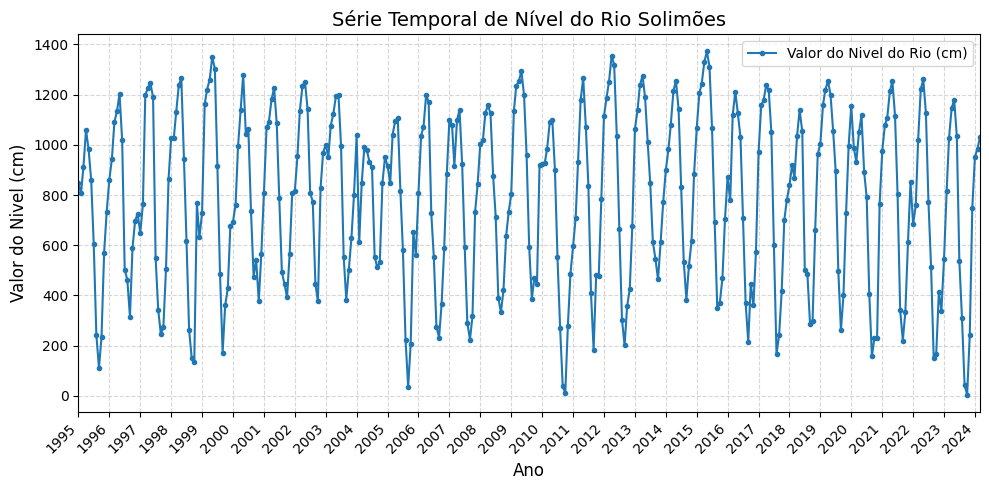

In [9]:
# --- 1. Preparação dos Dados (Exemplo) ---

# Certifique-se de que a coluna 'Data' está no formato datetime
#df['Data'] = pd.to_datetime(df['Data'])
# Ordene os dados pela data, caso não estejam
#df = df.sort_values(by='Data')
#df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')
# --- 2. Criação do Gráfico ---
fig, ax = plt.subplots(figsize=(10, 5)) # Ajuste o tamanho conforme necessário

# Plotar a série temporal completa (todos os pontos mensais)
ax.plot(dados_final.index, dados_final['nivel'], marker='.', linestyle='-', label='Valor do Nivel do Rio (cm)')

# --- 3. Configuração do Eixo Horizontal (Apenas Anos) ---
# Definir o localizador principal para mostrar ticks no início de cada ano
ax.xaxis.set_major_locator(mdates.YearLocator())
# definir o ano de inicio do gráfico
ax.set_xlim(pd.to_datetime('1995-01-01'), pd.to_datetime('2024-03-01'))  # Ajuste o intervalo de datas conforme necessário

# Definir o formatador para mostrar apenas o ano "YYYY" (ex: 2020)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Opcional: se quiser ticks menores para os meses, sem rótulos
#ax.xaxis.set_minor_locator(mdates.MonthLocator())

# --- 4. Melhorias no Gráfico ---
ax.set_title('Série Temporal de Nível do Rio Solimões', fontsize=14)
ax.set_xlabel('Ano', fontsize=12)
ax.set_ylabel('Valor do Nivel (cm)', fontsize=12)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

# Rotacionar os rótulos do eixo X para melhor visualização (pode não ser necessário se forem poucos anos)
plt.xticks(rotation=45, ha='right')

# Ajustar o layout para evitar que os rótulos se sobreponham ou sejam cortados
plt.tight_layout()

# Mostrar o gráfico
plt.show()

In [10]:
# plotar a serie temporal de cada ano
# for ano in dados_final.index.year.unique():
#     # Filtra o DataFrame para o ano atual
#     df_ano = dados_final[dados_final.index.year == ano]
    
#     # Cria a figura e o eixo para o gráfico
#     plt.figure(figsize=(10, 4))
    
#     # --- CORREÇÃO APLICADA AQUI ---
#     # Plota usando o índice para o eixo X e a coluna 'Media' para o eixo Y
#     plt.plot(df_ano.index, df_ano['nivel'], marker='.', linestyle='-', label=f'Valor do Nível - {ano}')
    
#     # Configurações do gráfico
#     plt.title(f'Série Temporal do Nível - {ano}', fontsize=14)
#     plt.xlabel('Data', fontsize=12)
#     plt.ylabel('Valor do Nível (cm)', fontsize=12)
#     plt.legend()
#     plt.grid(True, linestyle='--', alpha=0.7)
#     plt.xticks(rotation=45, ha='right')
    
#     # Ajusta o layout para evitar sobreposição de elementos
#     plt.tight_layout()
    
#     # Mostra o gráfico
#     plt.show()



In [10]:
# decompor a série temporal em tendência, sazonalidade e resíduo
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

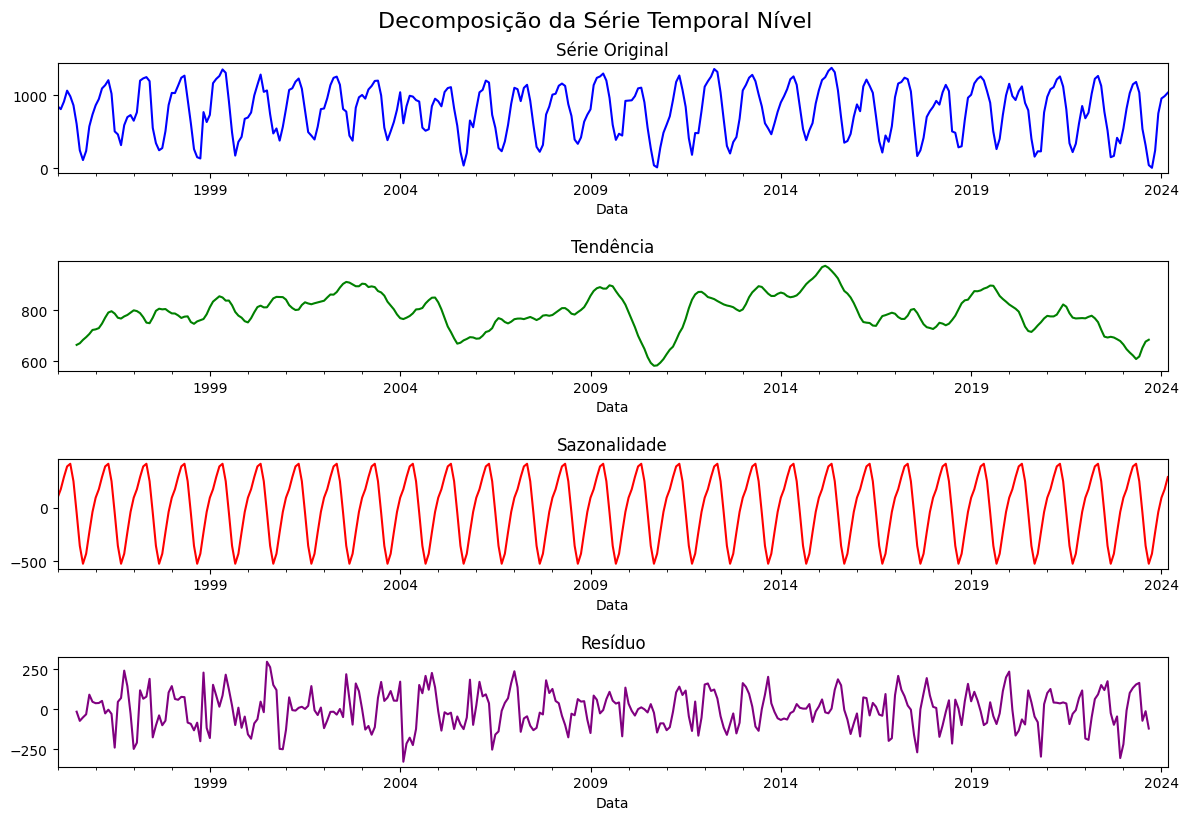

In [11]:
# decompor a série temporal em tendência, sazonalidade e resíduo e salvar essas series em variáveis diferentes

def decompor_serie(serie: pd.Series, periodo: int = 12, modelo: str = 'additive'):
    """
    Decompõe série temporal em 3 componentes:
    - tendência: padrão de longo prazo
    - sazonalidade: flutuações periódicas
    - resíduo: variação não explicada
    
    Parâmetros:
        periodo: ciclo sazonal (12 para mensal, 4 para trimestral)
        modelo: 'additive' (valores absolutos constantes) ou 'multiplicative' (valores relativos)
    """
    try:
        decomposicao = seasonal_decompose(
            serie.dropna(), 
            period=periodo, 
            model=modelo
        )
        
        componentes = {
            'original': serie,
            'tendencia': decomposicao.trend,
            'sazonalidade': decomposicao.seasonal,
            'residuo': decomposicao.resid
        }
        
        # Plotar componentes
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))
        
        componentes['original'].plot(ax=ax1, title='Série Original', color='blue')
        componentes['tendencia'].plot(ax=ax2, title='Tendência', color='green')
        componentes['sazonalidade'].plot(ax=ax3, title='Sazonalidade', color='red')
        componentes['residuo'].plot(ax=ax4, title='Resíduo', color='purple')
        
        plt.tight_layout()
        #plotar titulo da figura
        plt.suptitle('Decomposição da Série Temporal Nível', fontsize=16, y=1.02)
        plt.subplots_adjust(hspace=0.8)  # Ajustar o espaçamento entre os subgráficos
        plt.xlabel('Data')
        plt.show()
        
        return componentes
        
    except Exception as e:
        print(f"Erro: {str(e)}")
        print("Verifique: \n1. Série tem >=2 ciclos completos\n2. Modelo adequado (aditivo/multiplicativo)")
        return None



# Decompor e salvar componentes --------------------------------------------------
componentes = decompor_serie(dados_final['nivel'], periodo=12)

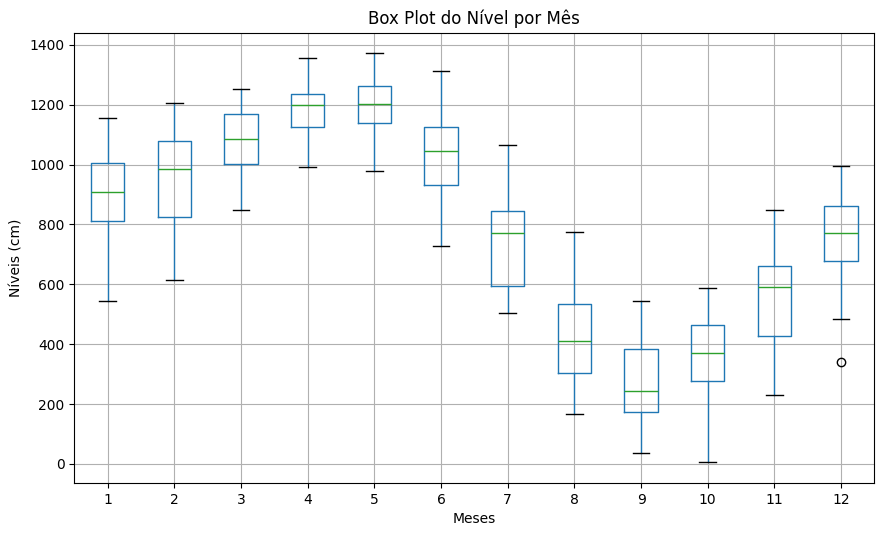

In [12]:
#Box-plot

# Assuming 'df' already has a 'Month' column
dados_final['Month'] = dados_final.index.month

dados_final.boxplot(column='nivel', by='Month', figsize=(10, 6))
plt.title('Box Plot do Nível por Mês')
plt.suptitle('')  # Remove the automatic 'Boxplot grouped by Month' title
plt.xlabel("Meses")
plt.ylabel("Níveis (cm)")
plt.grid(True)
plt.show()

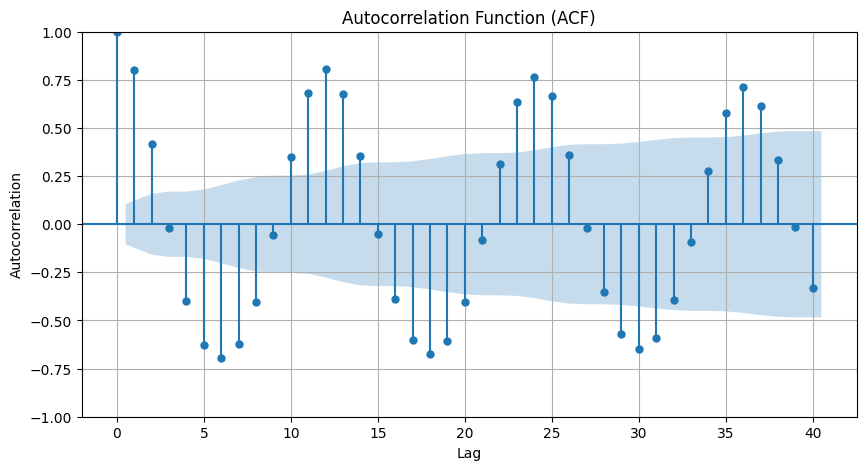

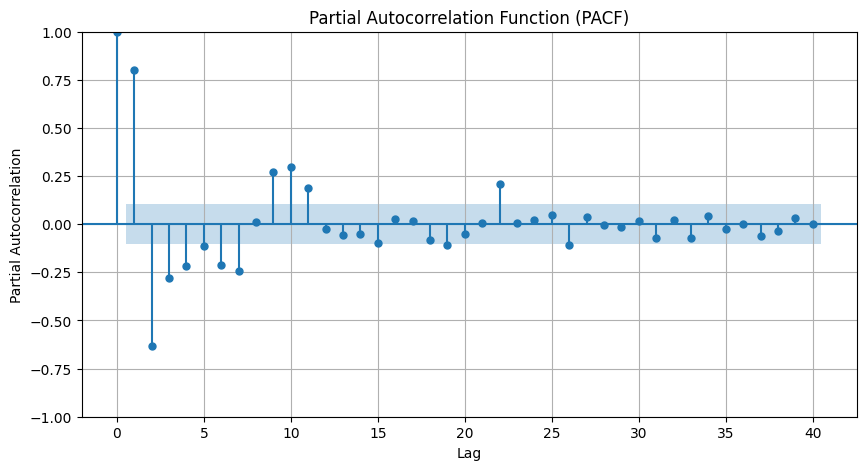

In [13]:
#Criando um gráfico de acf e pacf

#The ACF plot shows the correlation between a time series and its lagged values.
#The PACF plot shows the correlation between a time series and its lagged values, controlling for the correlations at intermediate lags.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Create the ACF plot
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(dados_final['nivel'], lags=40, ax=ax)  # Adjust lags as needed
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid()
plt.show()

# Create the PACF plot
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(dados_final['nivel'], lags=40, ax=ax)  # Adjust lags as needed
plt.title("Partial Autocorrelation Function (PACF)")
plt.xlabel("Lag")
plt.ylabel("Partial Autocorrelation")
plt.grid()
plt.show()


In [15]:
#Teste para Sazonalidade

#Ho: NÃO apresenta sazonalidade
#Ha: Apresenta sazonalidade

from scipy.stats import kruskal


# Extraindo os meses dos dados
dados_final['Month'] = dados_final.index.month

mensal_nivel = [dados_final['nivel'][dados_final['Month'] == m] for m in range(1, 13)]

statistic, p_value = kruskal(*mensal_nivel)

# Apresente o Resultado
print(f"Kruskal-Wallis Statistic: {statistic:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretação
if p_value < 0.05:
    print("Existe evidência de sazonalidade na série.")
else:
    print("Não existe evidência de sazonalidade na série.")


Kruskal-Wallis Statistic: 289.0309
P-value: 0.0000
Existe evidência de sazonalidade na série.


In [16]:
# realizar o teste de Dickey-Fuller aumentado (ADF) para verificar a estacionaridade da série temporal
from statsmodels.tsa.stattools import adfuller

def teste_adf(dados_final: pd.Series, alpha: float = 0.05):
    """
    Realiza o teste de Dickey-Fuller Aumentado (ADF) e exibe os resultados
    
    Parâmetros:
        serie: Série temporal a ser testada
        alpha: Nível de significância (padrão: 0.05)
    """
    try:
        resultado = adfuller(dados_final.dropna(), autolag='AIC')
    except ModuleNotFoundError:
        raise Exception("statsmodels não instalado. Execute: pip install statsmodels")
    
    # Organizar os resultados
    saida = {
        'Estatística ADF': resultado[0],
        'Valor-p': resultado[1],
        'Lags usados': resultado[2],
        'Observações': resultado[3],
        'Valores Críticos': resultado[4]
    }
    
    # Exibir resultados
    print(f"Teste de Dickey-Fuller Aumentado ({dados_final.name})")
    print("-" * 50)
    print(f"Estatística ADF: {saida['Estatística ADF']:.4f}")
    print(f"Valor-p: {saida['Valor-p']:.4f}")
    
    print("\nValores Críticos:")
    for key, value in saida['Valores Críticos'].items():
        print(f"{key}: {value:.4f}")
    
    print("\nConclusão:")
    if saida['Valor-p'] < alpha:
        print(f"Rejeitamos H0 (p={saida['Valor-p']:.4f} < {alpha}). Série ESTACIONÁRIA")
    else:
        print(f"Não rejeitamos H0 (p={saida['Valor-p']:.4f} ≥ {alpha}). Série NÃO ESTACIONÁRIA")

# Executar o teste ADF na série temporal
teste_adf(dados_final['nivel'])


Teste de Dickey-Fuller Aumentado (nivel)
--------------------------------------------------
Estatística ADF: -4.4056
Valor-p: 0.0003

Valores Críticos:
1%: -3.4500
5%: -2.8702
10%: -2.5714

Conclusão:
Rejeitamos H0 (p=0.0003 < 0.05). Série ESTACIONÁRIA


In [17]:
# realizar teste Kwiatkowski Phillips Schimidt Shin(KPSS) para verificar a estacionaridade da série temporal

from statsmodels.tsa.stattools import kpss

def teste_kpss(serie: pd.Series, alpha: float = 0.05):
    """
    Realiza o teste KPSS para verificação de estacionaridade
    
    Parâmetros:
        serie: Série temporal (pd.Series)
        alpha: Nível de significância (default: 0.05)
    """
    try:
        # Executar teste KPSS
        estatistica, p_valor, n_lags, valores_criticos = kpss(serie.dropna(), regression='c', nlags='auto')
        
        # Exibir resultados
        print(f"Teste KPSS: {serie.name}")
        print("="*50)
        print(f"Estatística KPSS: {estatistica:.4f}")
        print(f"Valor-p: {p_valor:.4f}")
        print(f"Número de lags: {n_lags}")
        
        print("\nValores Críticos:")
        for nivel, valor in valores_criticos.items():
            print(f"{nivel}%: {valor:.4f}")
        
        # Interpretação
        print("\nHipóteses:")
        print("H0: A série é estacionária (não há raiz unitária)")
        print("H1: A série não é estacionária (presença de raiz unitária)")
        
        print("\nConclusão:")
        if p_valor < alpha:
            print(f"Rejeitamos H0 (p={p_valor:.4f} < {alpha}) → Série NÃO ESTACIONÁRIA")
        else:
            print(f"Não rejeitamos H0 (p={p_valor:.4f} ≥ {alpha}) → Série ESTACIONÁRIA")
            
    except Exception as e:
        print(f"Erro no teste KPSS: {str(e)}")
        print("Verifique a instalação: !pip install statsmodels")


# Executar teste
teste_kpss(dados_final['nivel'])


Teste KPSS: nivel
Estatística KPSS: 0.0459
Valor-p: 0.1000
Número de lags: 7

Valores Críticos:
10%%: 0.3470
5%%: 0.4630
2.5%%: 0.5740
1%%: 0.7390

Hipóteses:
H0: A série é estacionária (não há raiz unitária)
H1: A série não é estacionária (presença de raiz unitária)

Conclusão:
Não rejeitamos H0 (p=0.1000 ≥ 0.05) → Série ESTACIONÁRIA


C:\Users\edfra\AppData\Local\Temp\ipykernel_14492\2167862661.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  estatistica, p_valor, n_lags, valores_criticos = kpss(serie.dropna(), regression='c', nlags='auto')


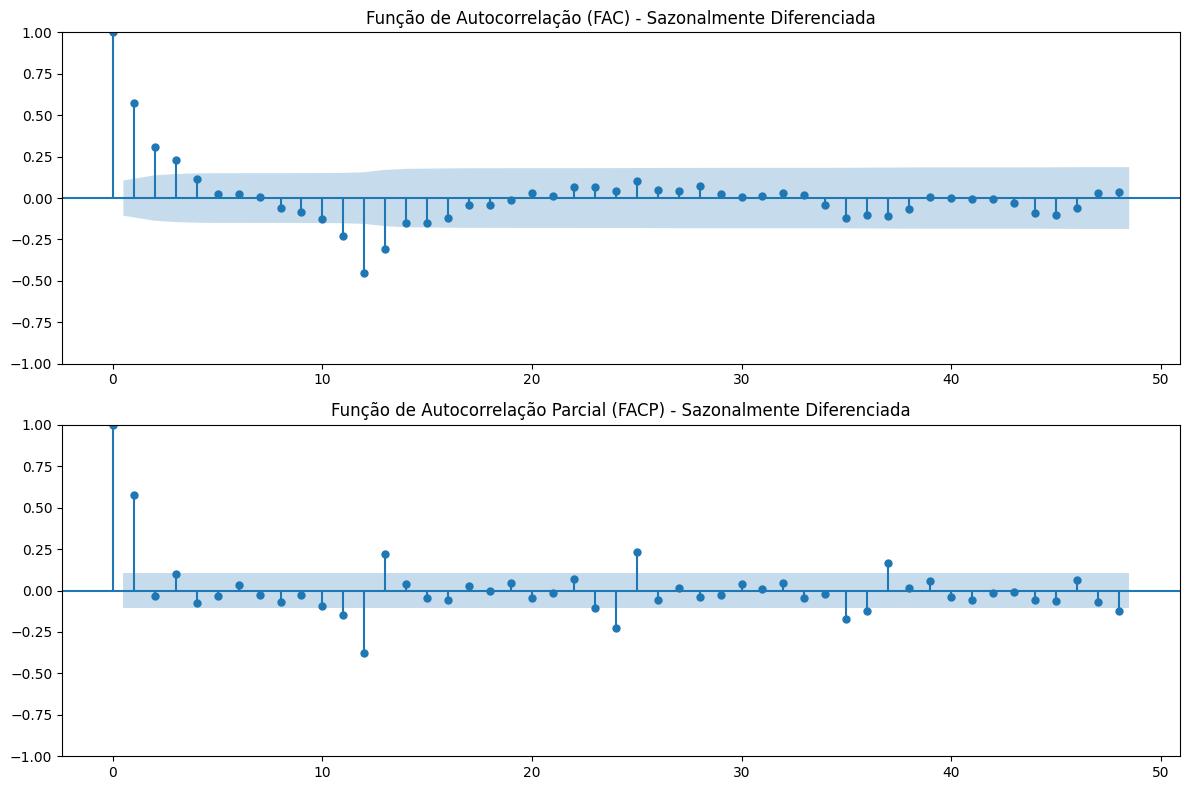

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Supondo que 'dados_final' é o seu DataFrame com a coluna 'nivel'
# e o índice de data já configurado.

# PASSO 1: Aplicar a diferenciação sazonal que os testes indicaram (D=1, m=12)
dados_diferenciados = dados_final['nivel'].diff(12).dropna()

# PASSO 2: Gerar os gráficos ACF e PACF na série diferenciada
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Gráfico ACF
plot_acf(dados_diferenciados, ax=ax1, lags=48) # Aumentar os lags para ver a parte sazonal
ax1.set_title('Função de Autocorrelação (FAC) - Sazonalmente Diferenciada')

# Gráfico PACF
plot_pacf(dados_diferenciados, ax=ax2, lags=48) # Aumentar os lags para ver a parte sazonal
ax2.set_title('Função de Autocorrelação Parcial (FACP) - Sazonalmente Diferenciada')

plt.tight_layout()
plt.show()



## O modelo

Tamanho do Treino: 347 observações
Tamanho do Teste: 4 observações
------------------------------


c:\Users\edfra\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: solver. After release 0.14, this will raise.
  warnings.warn(
c:\Users\edfra\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                nivel   No. Observations:                  347
Model:             SARIMAX(2, 0, 4)x(1, 1, [1], 12)   Log Likelihood               -1511.629
Date:                              Wed, 30 Jul 2025   AIC                           3043.259
Time:                                      10:05:34   BIC                           3081.400
Sample:                                  01-01-1995   HQIC                          3058.464
                                       - 11-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vazao          0.0258      0.000     69.868      0.000       0.025       0.027
ar.L1          1.17

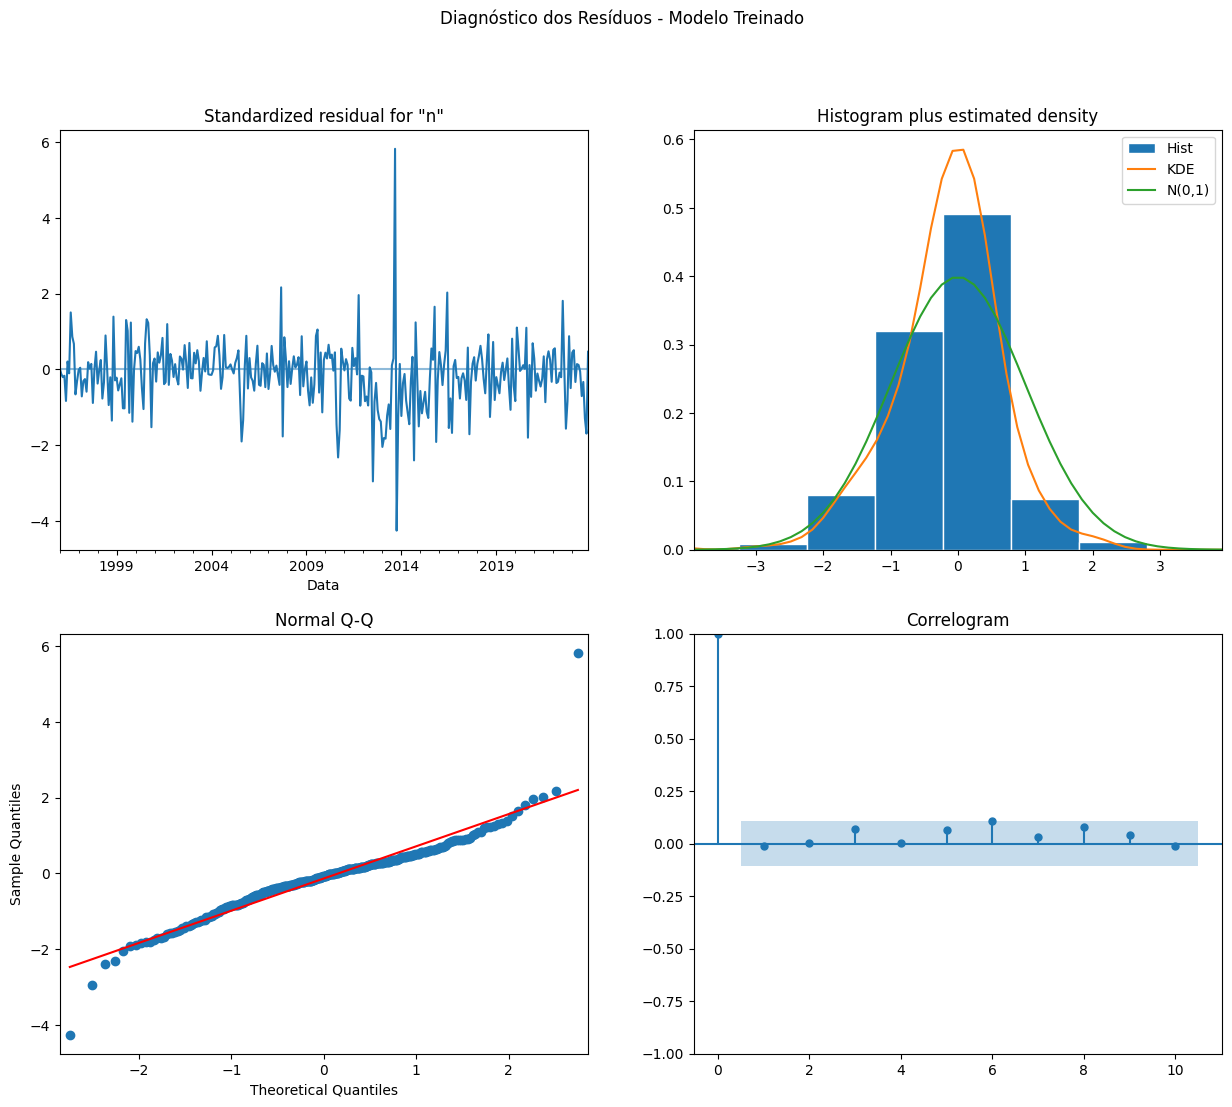

In [19]:
# --- MODELO SARIMAX FINAL (SIMPLIFICADO) ---


# Definindo as datas de corte para garantir que não haja sobreposição.
# Usamos o final do mês para clareza.
train_end_date = '2023-11-01'
#validation_end_date = '2023-11-01' # 4 meses após o treino (Ago, Set, Out, Nov)

# Fatiando o DataFrame principal nos três conjuntos
train_data = dados_final.loc['1995-01-01':train_end_date]
#validation_data = dados_final.loc['2023-08-01':validation_end_date]
# Os últimos 4 meses do período solicitado (Dez/23, Jan/24, Fev/24, Mar/24)
test_data = dados_final.loc['2023-12-01':'2024-03-01']

print(f"Tamanho do Treino: {len(train_data)} observações")
#print(f"Tamanho da Validação: {len(validation_data)} observações")
print(f"Tamanho do Teste: {len(test_data)} observações")
print("-" * 30)


# --- 2. Treinamento do Modelo (APENAS com dados de treino) ---

# Seus dados endog e exog são extraídos APENAS do conjunto de treinamento
endog_train = train_data['nivel']
exog_train = train_data[['vazao']]

# Definir e ajustar o modelo SARIMAX REFINADO
# Ordem: (p=1, d=0, q=0)
# Ordem Sazonal: (P=1, D=1, Q=0, m=12)
model_sarimax = sm.tsa.SARIMAX(
    endog_train,
    exog=exog_train,
    order=(2, 0, 4),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=True,
    enforce_invertibility=True
)

results_sarimax = model_sarimax.fit(disp=False, solver='powell')
print(results_sarimax.summary())

# Diagnóstico dos resíduos do modelo treinado
results_sarimax.plot_diagnostics(figsize=(15, 12))
plt.suptitle("Diagnóstico dos Resíduos - Modelo Treinado")
plt.show()



Tamanho do Treino: 347 observações
Tamanho do Teste: 4 observações
------------------------------
                                     SARIMAX Results                                      
Dep. Variable:                              nivel   No. Observations:                  347
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood               -1526.460
Date:                            Wed, 30 Jul 2025   AIC                           3060.920
Time:                                    10:06:00   BIC                           3076.177
Sample:                                01-01-1995   HQIC                          3067.003
                                     - 11-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vazao          0

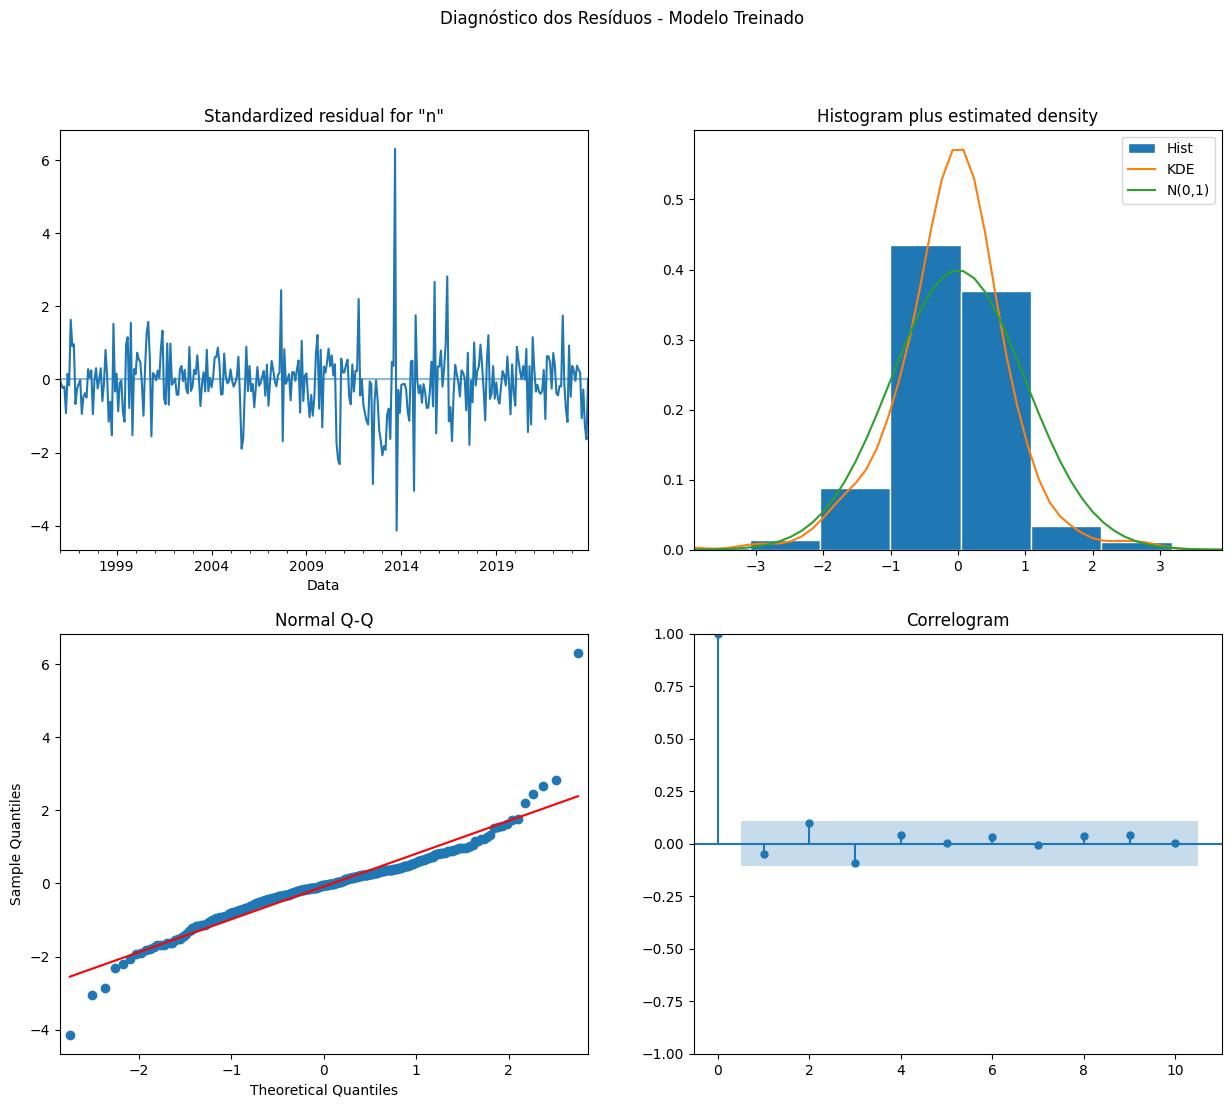

In [20]:
# --- 1. Divisão dos Dados (Train, Validation, Test) ---

# Definindo as datas de corte para garantir que não haja sobreposição.
# Usamos o final do mês para clareza.
train_end_date = '2023-11-01'
#validation_end_date = '2023-11-01' # 4 meses após o treino (Ago, Set, Out, Nov)

# Fatiando o DataFrame principal nos três conjuntos
train_data = dados_final.loc['1995-01-01':train_end_date]
#validation_data = dados_final.loc['2023-08-01':validation_end_date]
# Os últimos 4 meses do período solicitado (Dez/23, Jan/24, Fev/24, Mar/24)
test_data = dados_final.loc['2023-12-01':'2024-03-01']

print(f"Tamanho do Treino: {len(train_data)} observações")
#print(f"Tamanho da Validação: {len(validation_data)} observações")
print(f"Tamanho do Teste: {len(test_data)} observações")
print("-" * 30)


# --- 2. Treinamento do Modelo (APENAS com dados de treino) ---

# Seus dados endog e exog são extraídos APENAS do conjunto de treinamento
endog_train = train_data['nivel']
exog_train = train_data[['vazao']]

# Definir e ajustar o modelo SARIMAX REFINADO
# Ordem: (p=1, d=0, q=0)
# Ordem Sazonal: (P=1, D=1, Q=0, m=12)
model_sarimax2 = sm.tsa.SARIMAX(
    endog_train,
    exog=exog_train,
    order=(1, 0, 0),
    seasonal_order=(1, 1, 0, 12),
    enforce_stationarity=True,
    enforce_invertibility=True
)

results_sarimax2 = model_sarimax2.fit(disp=False)
print(results_sarimax2.summary())

# Diagnóstico dos resíduos do modelo treinado
results_sarimax2.plot_diagnostics(figsize=(15, 12))
plt.suptitle("Diagnóstico dos Resíduos - Modelo Treinado")
plt.show()



--- Previsão do Nível para os Próximos 4 Meses ---
               Previsão  IC Inferior (95%)  IC Superior (95%)
2023-12-01   723.982994         674.521502         773.444486
2024-01-01   953.070793         897.196653        1008.944932
2024-02-01   993.380787         935.861879        1050.899694
2024-03-01  1028.919668         970.954850        1086.884487


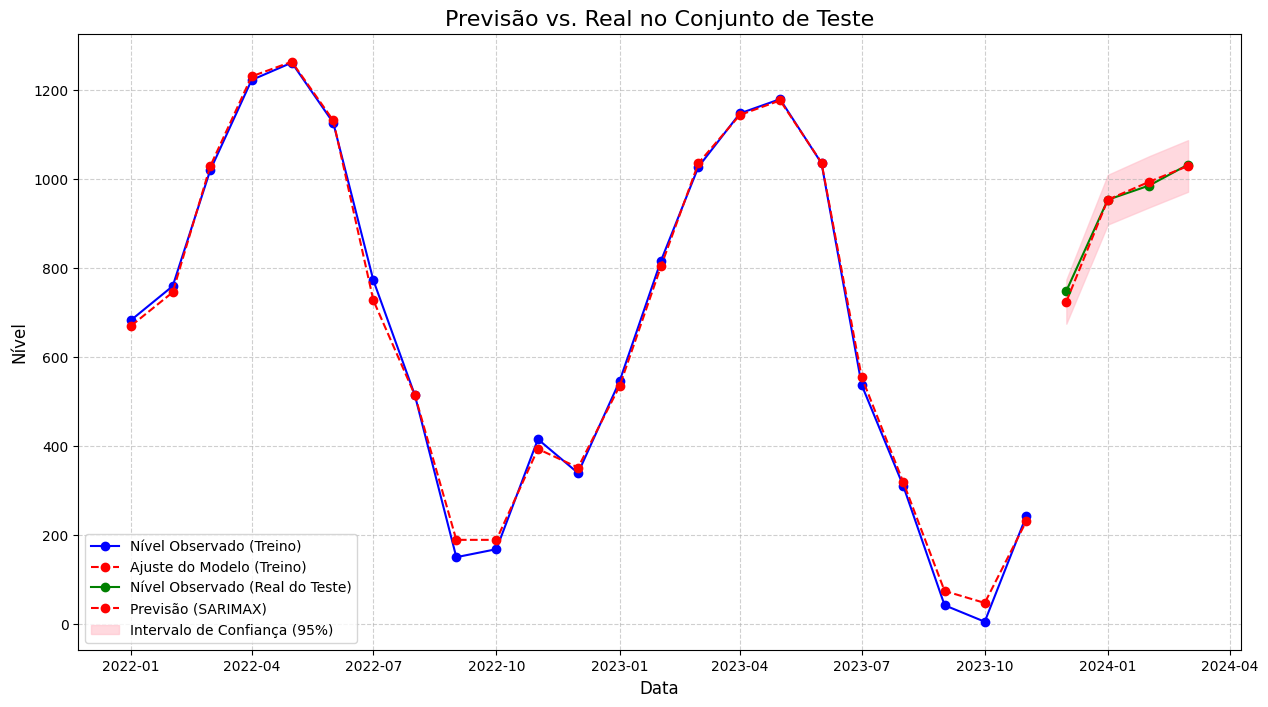

In [21]:
# --- PASSO 3: Previsão no período de TESTE ---

# Preparar os dados exógenos para o período de previsão (está correto)
# Renomeei para 'exog_test' para maior clareza
exog_test = test_data[['vazao']]

# Gerar a previsão usando o modelo treinado
# Renomeei para 'forecast_test'
forecast_test = results_sarimax2.get_forecast(steps=len(test_data), exog=exog_test)

# Obter a previsão pontual e o intervalo de confiança
previsao = forecast_test.predicted_mean
intervalo_confianca = forecast_test.conf_int()


# --- PASSO 4: Imprimir os valores previstos ---
# Melhoria: usar len(test_data) para o número de meses ser dinâmico
print("--- Previsão do Nível para os Próximos {} Meses ---".format(len(test_data)))
tabela_previsao = pd.DataFrame({
    'Previsão': previsao,
    'IC Inferior (95%)': intervalo_confianca.iloc[:, 0],
    'IC Superior (95%)': intervalo_confianca.iloc[:, 1]
})
print(tabela_previsao)


# --- PASSO 5: Plotar o resultado (Corrigido) ---

plt.figure(figsize=(15, 8))

# 1. Plotar os dados históricos de treino (apenas o período recente para contexto)
plt.plot(train_data['nivel']['2022':], label='Nível Observado (Treino)', color='blue',marker='o')

# 2. NOVO: Plotar o ajuste do modelo SOBRE os dados de treino no mesmo período
plt.plot(results_sarimax.fittedvalues['2022':], label='Ajuste do Modelo (Treino)', color='red', linestyle='--', marker='o')

# 2. CORREÇÃO: Plotar os dados REAIS do período de teste para comparação
plt.plot(test_data['nivel'], label='Nível Observado (Real do Teste)', color='green', marker='o')

# 3. Plotar a previsão feita pelo modelo
plt.plot(previsao, label='Previsão (SARIMAX)', color='red', linestyle='--', marker='o')


# 4. Plotar a área do intervalo de confiança
plt.fill_between(intervalo_confianca.index,
                 intervalo_confianca.iloc[:, 0],
                 intervalo_confianca.iloc[:, 1], color='pink', alpha=0.6, label='Intervalo de Confiança (95%)')

plt.title('Previsão vs. Real no Conjunto de Teste', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Nível', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



In [22]:
# calcular o MAE (Erro Médio Absoluto), RMSE (Raiz do Erro Quadrático Médio) e MAPE
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
# Calcular o MAE (Erro Médio Absoluto)
mae = mean_absolute_error(test_data['nivel'], previsao)
# Calcular o RMSE (Raiz do Erro Quadrático Médio)
rmse = np.sqrt(mean_squared_error(test_data['nivel'], previsao))
# Calcular o MAPE (Erro Percentual Absoluto Médio)
mape = np.mean(np.abs((test_data['nivel'] - previsao) / test_data['nivel'])) * 100
# Exibir os resultados
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


MAE: 8.8872
RMSE: 12.8116
MAPE: 1.09%


In [23]:
# Supondo que 'results_sarimax_log' seja o resultado do seu modelo ajustado

# 1. Extrair os resíduos do modelo
residuos = results_sarimax.resid

# 2. Padronizar os resíduos (Média 0, Desvio Padrão 1)
# Isso é exatamente o que o gráfico "Standardized Residuals" mostra
residuos_padronizados = (residuos - residuos.mean()) / residuos.std()

# 3. Definir nosso limite. Um valor entre 2.5 e 3.5 é geralmente bom.
# Valores acima disso são outliers muito prováveis.
limite = 3.5

# 4. Filtrar para encontrar os resíduos que ultrapassam o limite (tanto positivos quanto negativos)
outliers = residuos_padronizados[abs(residuos_padronizados) > limite]

# 5. Ordenar os outliers pelos piores (maior valor absoluto) e exibi-los
if outliers.empty:
    print(f"Boas notícias! Nenhum outlier encontrado acima do limite de {limite} desvios padrão.")
else:
    print(f"--- Outliers Identificados (limite > {limite} desvios padrão) ---")
    # Ordena para mostrar os mais extremos primeiro
    outliers_ordenados = outliers.abs().sort_values(ascending=False)
    print("Os piores outliers (data e valor do resíduo padronizado) são:")
    print(outliers.loc[outliers_ordenados.index])

--- Outliers Identificados (limite > 3.5 desvios padrão) ---
Os piores outliers (data e valor do resíduo padronizado) são:
Data
1995-09-01   -6.172912
1995-08-01   -5.488874
1995-10-01   -5.478533
1995-11-01   -4.274086
1995-04-01   -4.214214
1995-07-01   -4.196706
1995-05-01   -4.102057
1995-03-01   -4.101713
1995-06-01   -4.049221
1995-12-01   -4.031093
1995-02-01   -4.026671
1995-01-01   -4.022297
2013-09-01    3.712756
dtype: float64


In [24]:
# --- PASSO 1: Preparar o DataFrame para o modelo final e parsimonioso ---
exog = dados_final[['vazao']]
exog_final = exog.copy()

# --- PASSO 2: Adicionar as 4 dummies que se provaram significativas ---

# Outliers isolados de 2010 e 2023
exog_final['outlier_2013-09-01'] = 0
exog_final.loc['2013-09-01', 'outlier_2013-09-01'] = 1


# Outliers significativos de 1995
# datas_outliers_1995_final = ['1995-01-01', '1995-02-01','1995-08-01', '1995-09-01', '1995-10-01'] 
# for data in datas_outliers_1995_final:
#     exog_final[f'outlier_{data}'] = 0
#     exog_final.loc[data, f'outlier_{data}'] = 1

print("DataFrame exog para o modelo final:")
print(exog_final.info())

DataFrame exog para o modelo final:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 351 entries, 1995-01-01 to 2024-03-01
Freq: MS
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   vazao               351 non-null    float64
 1   outlier_2013-09-01  351 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 16.3 KB
None


In [25]:
#mesclar dados_final['nivel'] e exog_final
#dados_final['nivel'] = dados_final['nivel'].astype(float)  # Garantir que a coluna 'nivel' seja do tipo float
dados_final = pd.merge(dados_final['nivel'], exog_final, left_index=True, right_index=True, how='left')
# excluir vazao_x e Month
#dados_final = dados_final.drop(columns=['vazao_x', 'Month'])

In [26]:
dados_final

nivel      vazao  outlier_2013-09-01
Data                                             
1995-01-01   847.0  39711.438                   0
1995-02-01   807.0  38174.215                   0
1995-03-01   910.0  42288.590                   0
1995-04-01  1060.0  48282.215                   0
1995-05-01   983.0  45118.850                   0
...            ...        ...                 ...
2023-11-01   242.0  20786.166                   0
2023-12-01   748.0  38991.047                   0
2024-01-01   953.0  47248.580                   0
2024-02-01   985.0  48587.594                   0
2024-03-01  1032.0  50581.240                   0

[351 rows x 3 columns]

Tamanho do Treino: 347 observações
Tamanho do Teste: 4 observações
------------------------------
                                     SARIMAX Results                                      
Dep. Variable:                              nivel   No. Observations:                  347
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood               -1471.851
Date:                            Wed, 30 Jul 2025   AIC                           2953.702
Time:                                    10:07:08   BIC                           2972.772
Sample:                                01-01-1995   HQIC                          2961.304
                                     - 11-01-2023                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------


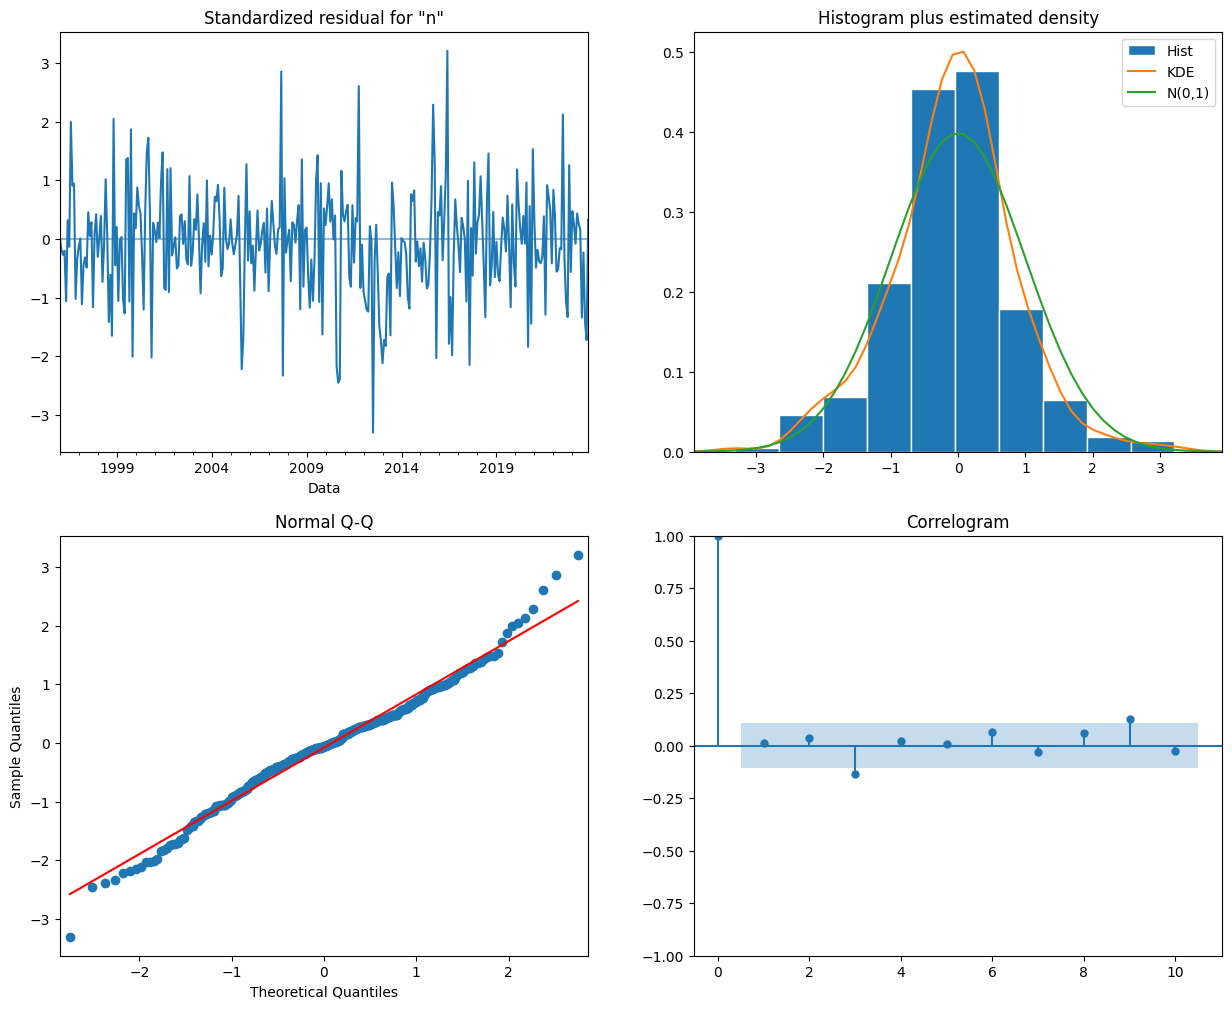

In [27]:
# Seus dados endog e exog já estão definidos
# endog = dados_final['nivel']
# exog = dados_final[['vazao']]
# --- 1. Divisão dos Dados (Train, Validation, Test) ---

# Definindo as datas de corte para garantir que não haja sobreposição.
# Usamos o final do mês para clareza.
train_end_date = '2023-11-01'
#validation_end_date = '2023-11-01' # 4 meses após o treino (Ago, Set, Out, Nov)

# Fatiando o DataFrame principal nos três conjuntos
train_data2 = dados_final.loc['1995-01-01':train_end_date]
#validation_data = dados_final.loc['2023-08-01':validation_end_date]
# Os últimos 4 meses do período solicitado (Dez/23, Jan/24, Fev/24, Mar/24)
test_data2 = dados_final.loc['2023-12-01':'2024-03-01']

print(f"Tamanho do Treino: {len(train_data2)} observações")
#print(f"Tamanho da Validação: {len(validation_data)} observações")
print(f"Tamanho do Teste: {len(test_data2)} observações")
print("-" * 30)


# --- 2. Treinamento do Modelo (APENAS com dados de treino) ---

# Seus dados endog e exog são extraídos APENAS do conjunto de treinamento
endog_train2 = train_data2['nivel']
exog_train2 = train_data2[['vazao', 'outlier_2013-09-01']]

# Definir e ajustar o modelo SARIMAX REFINADO
# Ordem: (p=1, d=0, q=0)
# Ordem Sazonal: (P=1, D=1, Q=0, m=12)
model_sarimax_out = sm.tsa.SARIMAX(
    endog_train2,
    exog=exog_train2,
    order=(1, 0, 0),
    seasonal_order=(1, 1, 0, 12),
    enforce_stationarity=True,
    enforce_invertibility=True
)

results_sarimax_out = model_sarimax_out.fit(disp=False)
print(results_sarimax_out.summary())

# Diagnóstico dos resíduos do novo modelo
results_sarimax_out.plot_diagnostics(figsize=(15, 12))
plt.show()

--- Previsão do Nível para os Próximos 4 Meses (Modelo Refinado) ---
            Nível Observado     Previsão  IC Inferior (95%)  IC Superior (95%)
2023-12-01            748.0   720.736556         679.167027         762.306085
2024-01-01            953.0   949.446922         900.334239         998.559605
2024-02-01            985.0   990.129090         938.333094        1041.925087
2024-03-01           1032.0  1026.324446         973.503920        1079.144973


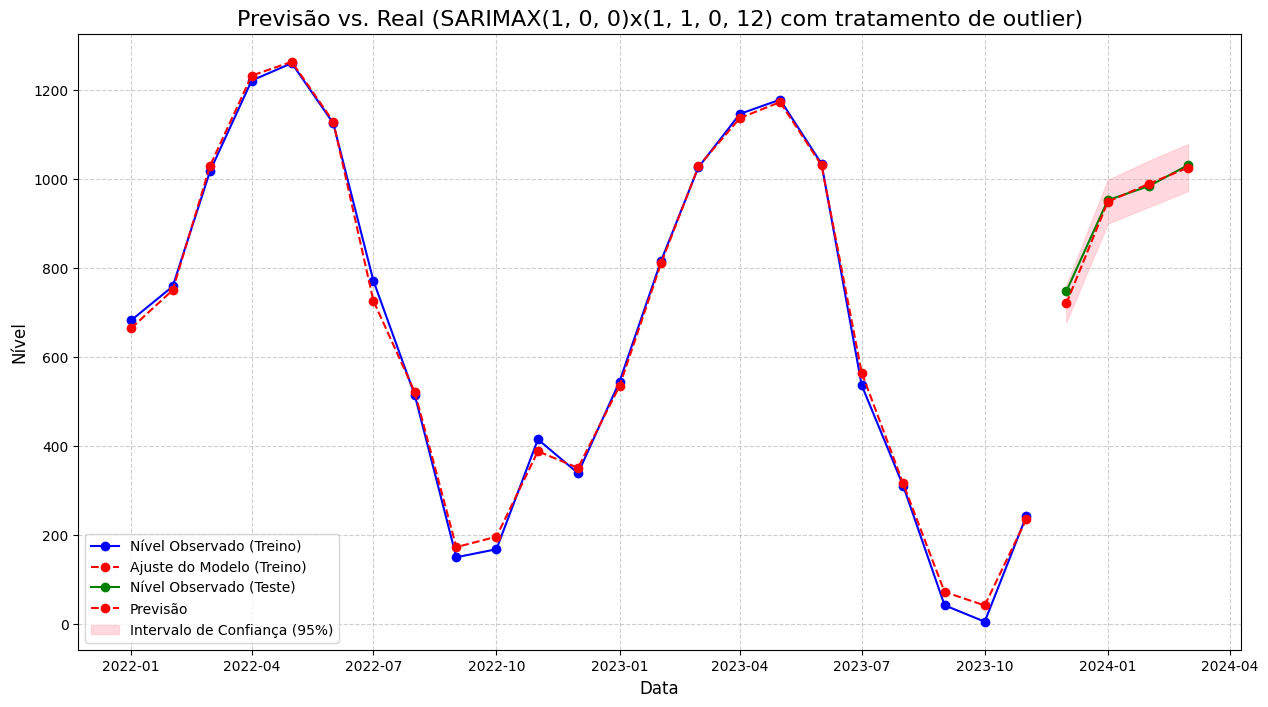

In [34]:
# --- 3. Próximos Passos (Validação e Teste) ---
# O código abaixo é um exemplo de como você usaria os outros conjuntos.
# --- PASSO 3: Previsão no período de TESTE (Corrigido) ---

# CORREÇÃO: Fornecer TODAS as variáveis exógenas que o modelo usou no treino.
# O nome da variável foi alterado para 'exog_test' para maior clareza.
exog_test = test_data2[['vazao', 'outlier_2013-09-01']]

# Gerar a previsão usando o modelo treinado e os dados exógenos de teste
forecast_out = results_sarimax_out.get_forecast(steps=len(test_data2), exog=exog_test)

# Obter a previsão pontual (a média da distribuição da previsão)
previsao_out = forecast_out.predicted_mean

# Obter o intervalo de confiança da previsão
intervalo_confianca_out = forecast_out.conf_int()


# --- PASSO 4: Imprimir os valores previstos ---
print("--- Previsão do Nível para os Próximos {} Meses (Modelo Refinado) ---".format(len(test_data2)))
tabela_previsao_out = pd.DataFrame({'Nível Observado': test_data2['nivel'],
    'Previsão': previsao_out,
    'IC Inferior (95%)': intervalo_confianca_out.iloc[:, 0],
    'IC Superior (95%)': intervalo_confianca_out.iloc[:, 1]
})
print(tabela_previsao_out)


# --- PASSO 5: Plotar o resultado (com melhorias) ---

plt.figure(figsize=(15, 8))

# Plotar os dados históricos (vamos plotar apenas os últimos 2 anos para melhor visualização)
# Usamos 'train_data2' para garantir que estamos plotando apenas os dados de treino
plt.plot(train_data2['nivel']['2022':], label='Nível Observado (Treino)', color='blue',marker='o')

# 2. NOVO: Plotar o ajuste do modelo SOBRE os dados de treino no mesmo período
plt.plot(results_sarimax_out.fittedvalues['2022':], label='Ajuste do Modelo (Treino)', color='red', linestyle='--', marker='o')


# MELHORIA: Plotar os dados REAIS do período de teste para comparação
plt.plot(test_data2['nivel'], label='Nível Observado (Teste)', color='green', marker='o')

# Plotar a previsão
plt.plot(previsao_out, label='Previsão', color='red', linestyle='--',marker='o')

# Plotar o intervalo de confiança
plt.fill_between(intervalo_confianca_out.index,
                 intervalo_confianca_out.iloc[:, 0],
                 intervalo_confianca_out.iloc[:, 1], color='pink', alpha=0.6, label='Intervalo de Confiança (95%)')

plt.title('Previsão vs. Real (SARIMAX(1, 0, 0)x(1, 1, 0, 12) com tratamento de outlier)', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Nível', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



In [35]:
# calcular o MAE (Erro Médio Absoluto), RMSE (Raiz do Erro Quadrático Médio) e MAPE
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
# Calcular o MAE (Erro Médio Absoluto)
mae = mean_absolute_error(test_data2['nivel'], previsao_out)
# Calcular o RMSE (Raiz do Erro Quadrático Médio)
rmse = np.sqrt(mean_squared_error(test_data2['nivel'], previsao_out))
# Calcular o MAPE (Erro Percentual Absoluto Médio)
mape = np.mean(np.abs((test_data2['nivel'] - previsao_out) / test_data2['nivel'])) * 100
# Exibir os resultados
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

MAE: 10.4053
RMSE: 14.2692
MAPE: 1.27%


--- Iniciando a Geração dos Modelos Baseline ---
Período de teste: de 2023-12 a 2024-03
--------------------------------------------------
Baseline Ingênuo: Previsão constante de 242.00
Baseline Ingênuo Sazonal: Previsões baseadas nos meses do ano anterior.
Baseline da Média: Previsão constante de 788.61
--------------------------------------------------
--- Resultados das Métricas de Erro (quanto menor, melhor) ---

--- Baseline: Ingênuo ---
  RMSE: 696.0075
  MAE:  687.5000  (O erro médio é de 687.50 unidades de 'nível')
  MAPE: 73.56%   (O erro médio é de 73.56% do valor real)

--- Baseline: Ingênuo Sazonal ---
  RMSE: 300.9697
  MAE:  247.7500  (O erro médio é de 247.75 unidades de 'nível')
  MAPE: 28.78%   (O erro médio é de 28.78% do valor real)

--- Baseline: Média ---
  RMSE: 177.8241
  MAE:  161.1971  (O erro médio é de 161.20 unidades de 'nível')
  MAPE: 16.55%   (O erro médio é de 16.55% do valor real)
--------------------------------------------------
Lembre-se de comparar 

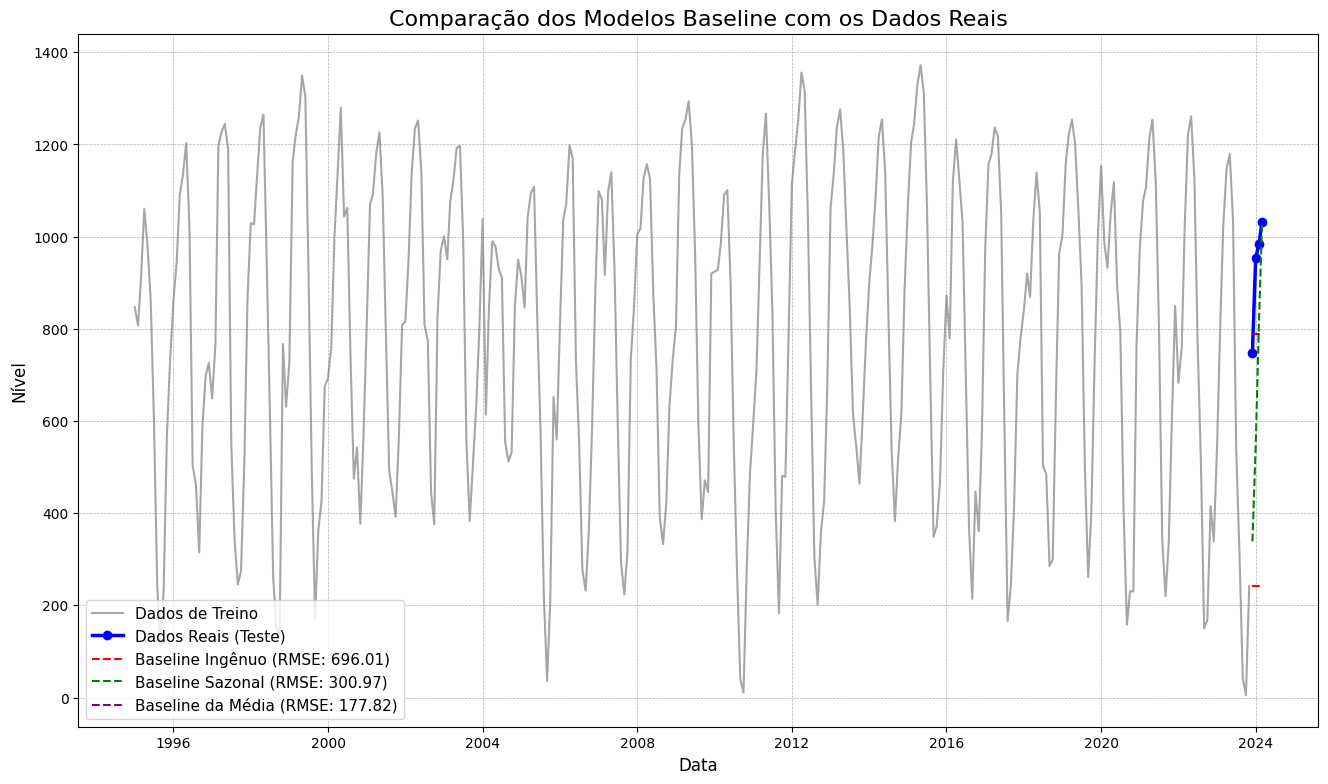

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Função para calcular o MAPE ---
# É bom ter uma função separada para lidar com casos onde o valor real (y_true) pode ser zero.
def calculate_mape(y_true, y_pred):
    """
    Calcula o Erro Percentual Médio Absoluto (MAPE).
    Remove os valores onde o dado real é zero para evitar divisão por zero.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Filtra os casos em que y_true é diferente de zero
    non_zero_mask = y_true != 0
    if not np.any(non_zero_mask):
        return np.inf # Retorna infinito se todos os valores verdadeiros forem zero
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# --- Etapa 1: Preparar o DataFrame de Teste ---
test_predictions = test_data2.copy()

print("--- Iniciando a Geração dos Modelos Baseline ---")
print(f"Período de teste: de {test_data2.index.min().strftime('%Y-%m')} a {test_data2.index.max().strftime('%Y-%m')}")
print("-" * 50)

# --- Etapa 2: Implementar os Baselines ---

# Baseline 1: Previsão Ingênua (Naive Forecast)
last_train_value = train_data2['nivel'].iloc[-1]
test_predictions['naive_forecast'] = last_train_value
print(f"Baseline Ingênuo: Previsão constante de {last_train_value:.2f}")

# Baseline 2: Previsão Ingênua Sazonal (Seasonal Naive Forecast)
seasonal_forecasts = []
for test_date in test_data2.index:
    prior_date = test_date - pd.DateOffset(years=1)
    try:
        seasonal_value = train_data2.loc[prior_date, 'nivel']
        seasonal_forecasts.append(seasonal_value)
    except KeyError:
        seasonal_forecasts.append(last_train_value)
test_predictions['seasonal_naive_forecast'] = seasonal_forecasts
print("Baseline Ingênuo Sazonal: Previsões baseadas nos meses do ano anterior.")

# Baseline 3: Previsão pela Média (Mean Forecast)
mean_train_value = train_data2['nivel'].mean()
test_predictions['mean_forecast'] = mean_train_value
print(f"Baseline da Média: Previsão constante de {mean_train_value:.2f}")
print("-" * 50)

# --- Etapa 3: Avaliar o Desempenho com Múltiplas Métricas ---
print("--- Resultados das Métricas de Erro (quanto menor, melhor) ---")

# Valores reais de teste
y_true = test_predictions['nivel']

# Dicionário para armazenar as previsões para facilitar o loop
predictions = {
    "Ingênuo": test_predictions['naive_forecast'],
    "Ingênuo Sazonal": test_predictions['seasonal_naive_forecast'],
    "Média": test_predictions['mean_forecast']
}

# Dicionário para armazenar os resultados para o gráfico
results_metrics = {}

for name, y_pred in predictions.items():
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = calculate_mape(y_true, y_pred)
    
    results_metrics[name] = {'rmse': rmse, 'mae': mae, 'mape': mape}
    
    print(f"\n--- Baseline: {name} ---")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}  (O erro médio é de {mae:.2f} unidades de 'nível')")
    print(f"  MAPE: {mape:.2f}%   (O erro médio é de {mape:.2f}% do valor real)")

print("-" * 50)
print("Lembre-se de comparar estes valores com as métricas do seu modelo SARIMAX.")

# --- Etapa 4: Visualizar os Resultados ---
plt.figure(figsize=(16, 9))

# Dados históricos e reais
plt.plot(train_data2['nivel'], label='Dados de Treino', color='gray', alpha=0.7)
plt.plot(test_predictions['nivel'], label='Dados Reais (Teste)', color='blue', linewidth=2.5, marker='o')

# Previsões dos baselines (com RMSE na legenda para clareza visual)
plt.plot(test_predictions['naive_forecast'], label=f'Baseline Ingênuo (RMSE: {results_metrics["Ingênuo"]["rmse"]:.2f})', linestyle='--', color='red')
plt.plot(test_predictions['seasonal_naive_forecast'], label=f'Baseline Sazonal (RMSE: {results_metrics["Ingênuo Sazonal"]["rmse"]:.2f})', linestyle='--', color='green')
plt.plot(test_predictions['mean_forecast'], label=f'Baseline da Média (RMSE: {results_metrics["Média"]["rmse"]:.2f})', linestyle='--', color='purple')

plt.title('Comparação dos Modelos Baseline com os Dados Reais', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Nível', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


                                     SARIMAX Results                                      
Dep. Variable:                              nivel   No. Observations:                  351
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood               -1485.318
Date:                            Sun, 27 Jul 2025   AIC                           2978.636
Time:                                    00:04:10   BIC                           2993.783
Sample:                                01-01-1995   HQIC                          2984.681
                                     - 03-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vazao          0.0259      0.000     85.839      0.000       0.025       0.026
ar.L1          0.5169      0.031   

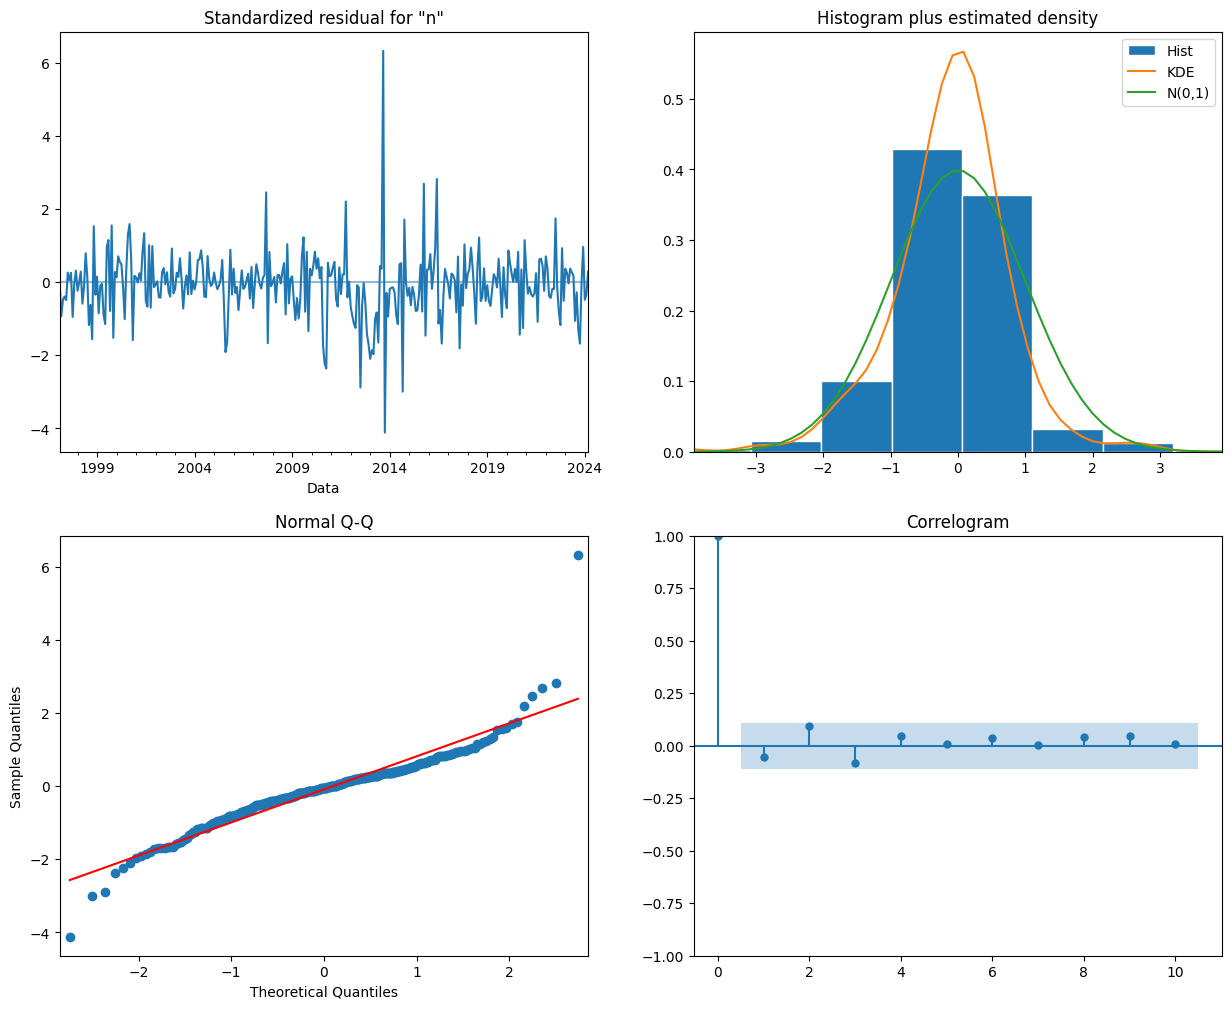

In [34]:
# Seus dados endog e exog já estão definidos
endog = dados_final['nivel']
exog = dados_final[['vazao']]

# Definir e ajustar o modelo SARIMAX REFINADO
# Ordem: (p=1, d=0, q=0)
# Ordem Sazonal: (P=1, D=1, Q=0, m=12)
model_sarimax = sm.tsa.SARIMAX(
    endog,
    exog=exog,
    order=(1, 0, 0),
    seasonal_order=(1, 1, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_sarimax = model_sarimax.fit(disp=False)
print(results_sarimax.summary())

# Diagnóstico dos resíduos do novo modelo
results_sarimax.plot_diagnostics(figsize=(15, 12))
plt.show()

In [35]:
# Supondo que 'dados_finais' é o seu DataFrame com o histórico de dados
# e que ele tem um índice de datas (DatetimeIndex) e uma coluna 'vazao'.

# --- PASSO 1: Calcular a mediana da vazão para cada mês do ano ---
# Agrupamos os dados pelo mês (1=Jan, 2=Fev, etc.) e calculamos a mediana da 'vazao'
medianas_mensais = dados_final.groupby(dados_final.index.month)['vazao'].median()

# O resultado 'medianas_mensais' será uma Series do pandas, algo como:
# 1    150.5
# 2    145.0
# 3    160.2
# ...
# 12   148.8


# --- PASSO 2: Definir os parâmetros para a previsão futura ---
n_steps = 12
mes_inicio = 4 # Abril


# --- PASSO 3: Criar a lista 'vazao_estimada_futuro' com base nas medianas ---

# Gera a sequência de meses para a previsão (ex: 4, 5, ..., 12, 1, 2, 3)
meses_futuros = [(mes_inicio + i - 1) % 12 + 1 for i in range(n_steps)]

# Para cada mês na sequência futura, busca sua respectiva mediana na tabela que criamos
vazao_estimada_futuro = [medianas_mensais[mes] for mes in meses_futuros]


# --- PASSO 4: Criar o DataFrame exog_futuro com esses valores ---

# Criar o índice de datas futuras (mesma lógica de antes)
future_dates = pd.date_range(start=dados_final.index[-1] + pd.DateOffset(months=1), periods=n_steps, freq='MS')

# Criar o DataFrame final para a previsão
exog_futuro = pd.DataFrame({
    'vazao': vazao_estimada_futuro
}, index=future_dates)


# --- Verificação Final ---
print("Valores da vazão futura estimados (baseado na mediana mensal):")
print(exog_futuro)

# Agora você pode usar 'exog_futuro' na sua função de previsão
# forecast = results_sarimax.get_forecast(steps=n_steps, exog=exog_futuro)
# ... etc ...


Valores da vazão futura estimados (baseado na mediana mensal):
                 vazao
2024-04-01  55600.9260
2024-05-01  57018.8400
2024-06-01  49604.6110
2024-07-01  37430.8900
2024-08-01  24860.0590
2024-09-01  19929.2010
2024-10-01  23253.9260
2024-11-01  30199.7680
2024-12-01  38225.8320
2025-01-01  43342.4320
2025-02-01  46748.1265
2025-03-01  50498.2940


--- Previsão do Nível para os Próximos 12 Meses (Modelo Refinado) ---
               Previsão  IC Inferior (95%)  IC Superior (95%)
2024-04-01  1142.407442        1093.099518        1191.715366
2024-05-01  1173.648981        1118.143018        1229.154943
2024-06-01  1001.231054         944.182854        1058.279255
2024-07-01   725.352482         667.899201         782.805763
2024-08-01   379.663670         322.102634         437.224707
2024-09-01   183.192153         125.602358         240.781948
2024-10-01   260.207883         202.610406         317.805359
2024-11-01   498.185376         440.585847         555.784905
2024-12-01   723.444445         665.844368         781.044523
2025-01-01   855.268665         797.668441         912.868890
2025-02-01   942.432243         884.831979        1000.032506
2025-03-01  1029.554419         971.954145        1087.154693


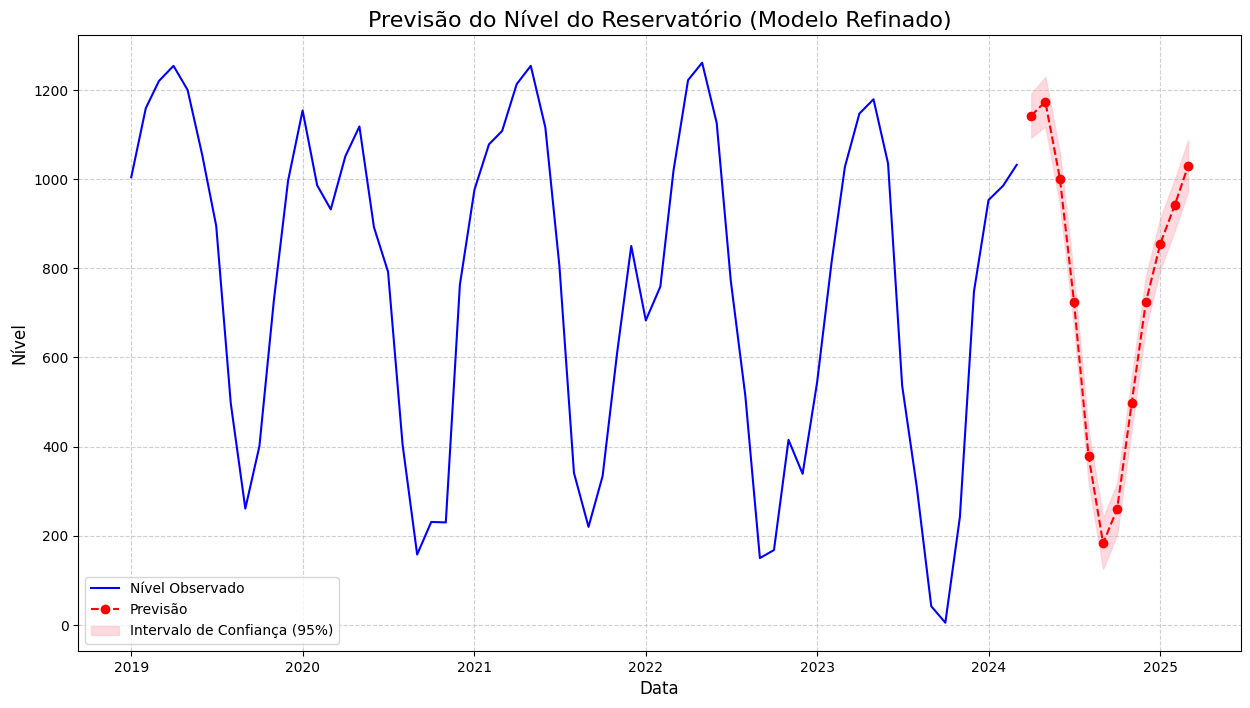

In [36]:
# --- PASSO 1: Preparar os dados para previsão ---

# Assumindo que 'results_sarimax_refinado' é o resultado do seu ajuste de modelo.
# 'endog' é a série 'nivel' original e 'exog' é o DataFrame com a 'vazao'.
# Seus dados:
# endog = dados_final['nivel']
# exog = dados_final[['vazao']]

# Definir quantos meses à frente queremos prever
n_steps = 12

# --- PASSO 2: Criar o DataFrame com a variável exógena para o período futuro ---

# Criar o índice de datas futuras
future_dates = pd.date_range(start=endog.index[-1] + pd.DateOffset(months=1), periods=n_steps, freq='MS')

# --- PASSO 1: Calcular a mediana da vazão para cada mês do ano ---
# Agrupamos os dados pelo mês (1=Jan, 2=Fev, etc.) e calculamos a mediana da 'vazao'
medianas_mensais = dados_final.groupby(dados_final.index.month)['vazao'].median()
mes_inicio = 4 # Abril
# --- PASSO 3: Criar a lista 'vazao_estimada_futuro' com base nas medianas ---

# Gera a sequência de meses para a previsão (ex: 4, 5, ..., 12, 1, 2, 3)
meses_futuros = [(mes_inicio + i - 1) % 12 + 1 for i in range(n_steps)]

# Para cada mês na sequência futura, busca sua respectiva mediana na tabela que criamos
vazao_estimada_futuro = [medianas_mensais[mes] for mes in meses_futuros]



# Criar o DataFrame exog_futuro somente com a vazão
exog_futuro = pd.DataFrame({
    'vazao': vazao_estimada_futuro
}, index=future_dates)


# --- PASSO 3: Gerar a previsão (já na escala original) ---
forecast = results_sarimax.get_forecast(steps=n_steps, exog=exog_futuro)

# Obter a previsão e o intervalo de confiança
previsao = forecast.predicted_mean
intervalo_confianca = forecast.conf_int()


# --- PASSO 4: Imprimir os valores previstos ---
print("--- Previsão do Nível para os Próximos {} Meses (Modelo Refinado) ---".format(n_steps))
tabela_previsao = pd.DataFrame({
    'Previsão': previsao,
    'IC Inferior (95%)': intervalo_confianca.iloc[:, 0],
    'IC Superior (95%)': intervalo_confianca.iloc[:, 1]
})
print(tabela_previsao)


# --- PASSO 5: Plotar o resultado ---

plt.figure(figsize=(15, 8))

# Plotar os dados históricos (vamos plotar apenas os últimos 5 anos para melhor visualização)
plt.plot(endog['2019':], label='Nível Observado', color='blue')

# Plotar a previsão
plt.plot(previsao, label='Previsão', color='red', marker='o', linestyle='--')

# Plotar o intervalo de confiança
plt.fill_between(intervalo_confianca.index,
                 intervalo_confianca.iloc[:, 0],
                 intervalo_confianca.iloc[:, 1], color='pink', alpha=0.6, label='Intervalo de Confiança (95%)')

plt.title('Previsão do Nível do Reservatório (Modelo Refinado)', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Nível', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [37]:
# Supondo que 'results_sarimax_log' seja o resultado do seu modelo ajustado

# 1. Extrair os resíduos do modelo
residuos = results_sarimax.resid

# 2. Padronizar os resíduos (Média 0, Desvio Padrão 1)
# Isso é exatamente o que o gráfico "Standardized Residuals" mostra
residuos_padronizados = (residuos - residuos.mean()) / residuos.std()

# 3. Definir nosso limite. Um valor entre 2.5 e 3.5 é geralmente bom.
# Valores acima disso são outliers muito prováveis.
limite = 3.5

# 4. Filtrar para encontrar os resíduos que ultrapassam o limite (tanto positivos quanto negativos)
outliers = residuos_padronizados[abs(residuos_padronizados) > limite]

# 5. Ordenar os outliers pelos piores (maior valor absoluto) e exibi-los
if outliers.empty:
    print(f"Boas notícias! Nenhum outlier encontrado acima do limite de {limite} desvios padrão.")
else:
    print(f"--- Outliers Identificados (limite > {limite} desvios padrão) ---")
    # Ordena para mostrar os mais extremos primeiro
    outliers_ordenados = outliers.abs().sort_values(ascending=False)
    print("Os piores outliers (data e valor do resíduo padronizado) são:")
    print(outliers.loc[outliers_ordenados.index])

--- Outliers Identificados (limite > 3.5 desvios padrão) ---
Os piores outliers (data e valor do resíduo padronizado) são:
Data
1995-09-01   -5.253662
1995-01-01   -5.106670
2013-09-01    4.917837
1995-08-01   -4.860484
1995-10-01   -4.075352
1995-02-01   -3.730478
dtype: float64


In [38]:
# --- PASSO 1: Preparar o DataFrame para o modelo final e parsimonioso ---
exog_final = exog.copy()

# --- PASSO 2: Adicionar as 4 dummies que se provaram significativas ---

# Outliers isolados de 2010 e 2023
exog_final['outlier_2013-09-01'] = 0
exog_final.loc['2013-09-01', 'outlier_2013-09-01'] = 1


# Outliers significativos de 1995
# datas_outliers_1995_final = ['1995-01-01', '1995-02-01','1995-08-01', '1995-09-01', '1995-10-01'] 
# for data in datas_outliers_1995_final:
#     exog_final[f'outlier_{data}'] = 0
#     exog_final.loc[data, f'outlier_{data}'] = 1

print("DataFrame exog para o modelo final:")
print(exog_final.info())

DataFrame exog para o modelo final:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 351 entries, 1995-01-01 to 2024-03-01
Freq: MS
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   vazao               351 non-null    float64
 1   outlier_2013-09-01  351 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 16.3 KB
None


In [27]:
exog_final

vazao  outlier_2013-09-01
Data                                     
1995-01-01  39711.438                   0
1995-02-01  38174.215                   0
1995-03-01  42288.590                   0
1995-04-01  48282.215                   0
1995-05-01  45118.850                   0
...               ...                 ...
2023-11-01  20786.166                   0
2023-12-01  38991.047                   0
2024-01-01  47248.580                   0
2024-02-01  48587.594                   0
2024-03-01  50581.240                   0

[351 rows x 2 columns]

                                     SARIMAX Results                                      
Dep. Variable:                              nivel   No. Observations:                  351
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood               -1431.777
Date:                            Thu, 24 Jul 2025   AIC                           2873.553
Time:                                    22:59:55   BIC                           2892.488
Sample:                                01-01-1995   HQIC                          2881.109
                                     - 03-01-2024                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
vazao                  0.0259      0.000    112.045      0.000       0.025       0.026
outlier_201

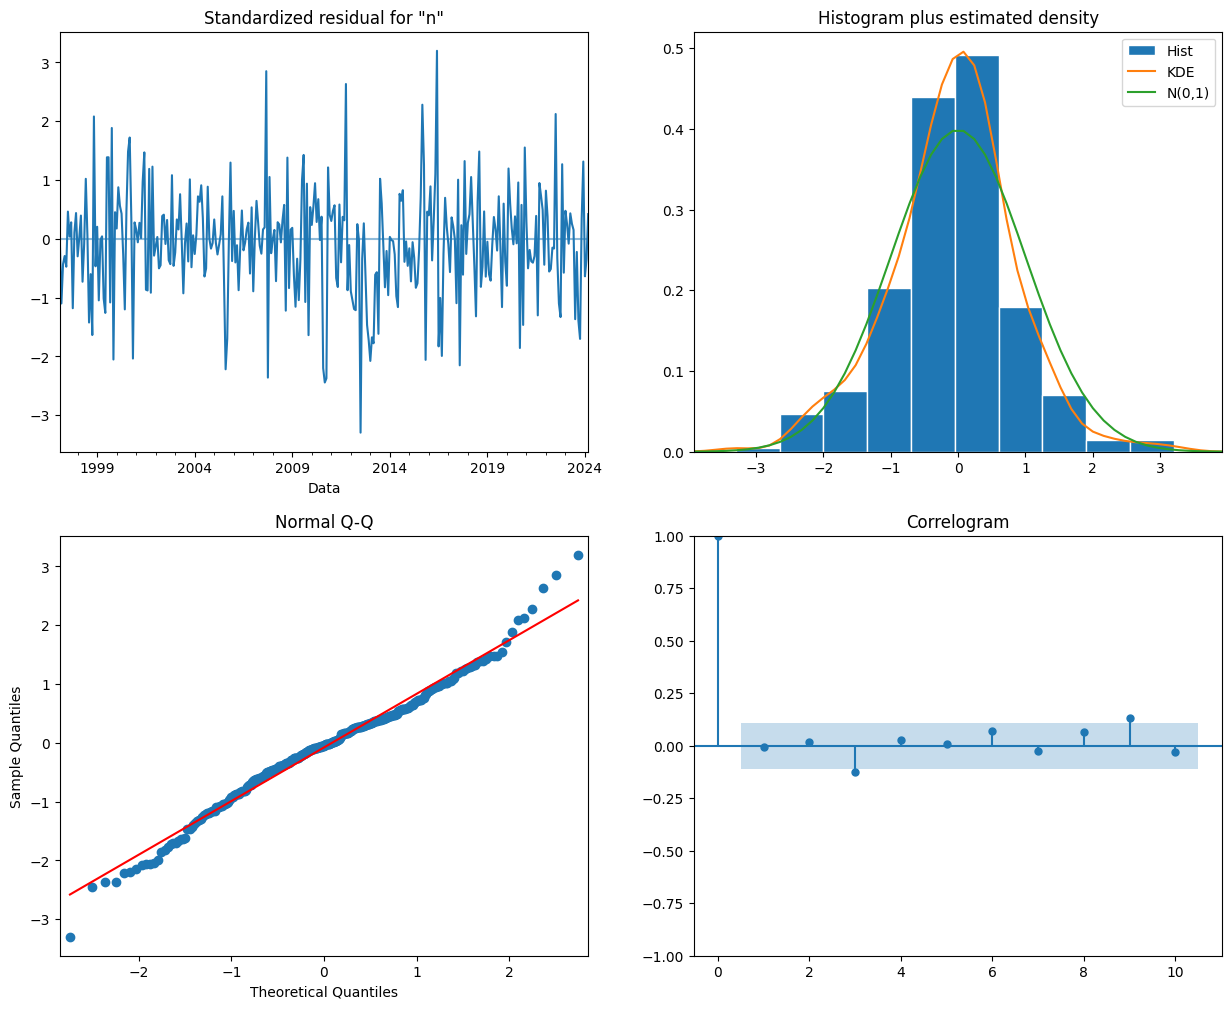

In [32]:
# Seus dados endog e exog já estão definidos
# endog = dados_final['nivel']
# exog = dados_final[['vazao']]

# Definir e ajustar o modelo SARIMAX REFINADO
# Ordem: (p=1, d=0, q=0)
# Ordem Sazonal: (P=1, D=1, Q=0, m=12)
model_sarimax_refinado = sm.tsa.SARIMAX(
    endog,
    exog=exog_final,
    order=(1, 0, 0),
    seasonal_order=(1, 1, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_sarimax_refinado = model_sarimax_refinado.fit(disp=False)
print(results_sarimax_refinado.summary())

# Diagnóstico dos resíduos do novo modelo
results_sarimax_refinado.plot_diagnostics(figsize=(15, 12))
plt.show()

               Previsão  IC Inferior (95%)  IC Superior (95%)
2024-04-01  1142.767381        1101.233416        1184.301347
2024-05-01  1174.058285        1124.786414        1223.330157
2024-06-01  1001.541347         949.446088        1053.636606
2024-07-01   724.427062         671.224722         777.629403
2024-08-01   378.751265         325.104541         432.397989
2024-09-01   182.336195         128.509519         236.162872
2024-10-01   259.145508         205.245706         313.045310
2024-11-01   497.613763         443.684205         551.543322
2024-12-01   723.976434         670.034760         777.918108
2025-01-01   855.125588         801.178980         909.072197
2025-02-01   942.118620         888.170002         996.067237
2025-03-01  1029.576795         975.627359        1083.526231


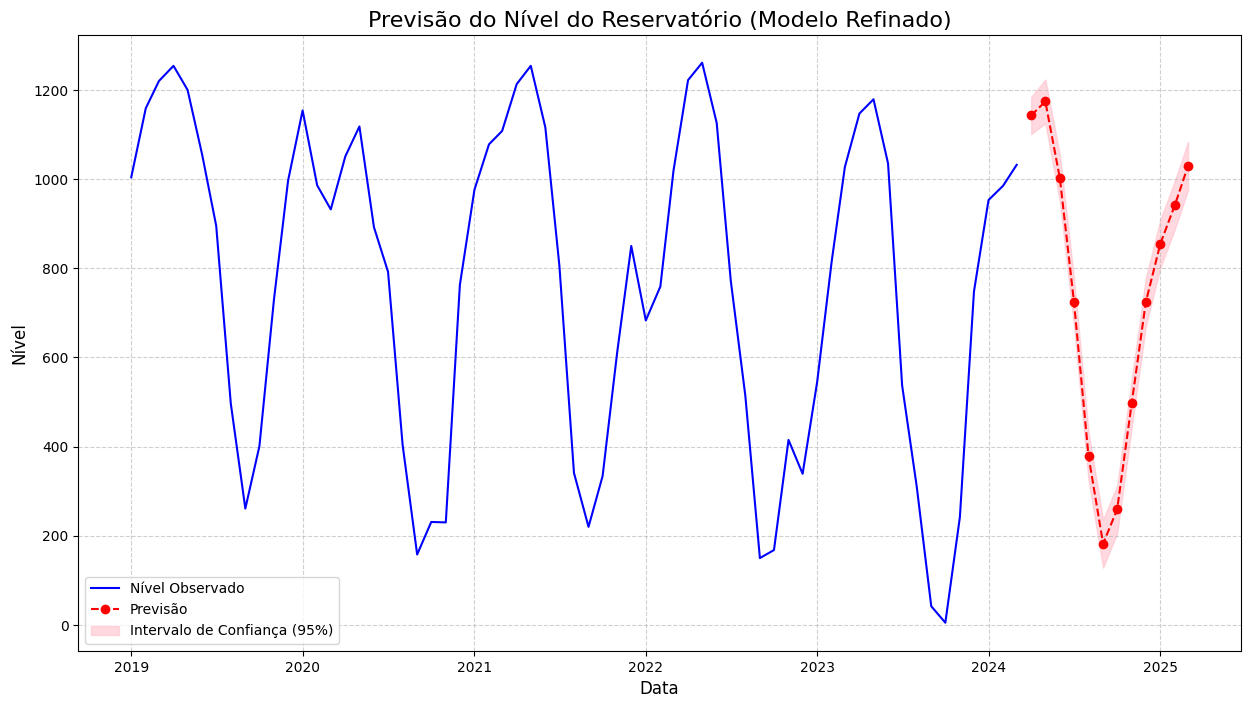

In [35]:
# Define o horizonte de previsão
n_steps = 12

# Cria as datas futuras
future_dates = pd.date_range(start=endog.index[-1] + pd.DateOffset(months=1), periods=n_steps, freq='MS')

# Calcula a mediana histórica da vazão para cada mês
medianas_mensais = dados_final.groupby(dados_final.index.month)['vazao'].median()

# Cria a lista de vazões futuras com base na sazonalidade (mediana)
mes_inicio = 4
meses_futuros = [(mes_inicio + i - 1) % 12 + 1 for i in range(n_steps)]
vazao_estimada_futuro = [medianas_mensais[mes] for mes in meses_futuros]

# --- Bloco Crítico: Montando o DataFrame exog_futuro ---
exog_futuro = pd.DataFrame(index=future_dates)
exog_futuro['vazao'] = vazao_estimada_futuro
exog_futuro['outlier_2013-09-01'] = 0 # <-- Ponto chave 1
exog_futuro = exog_futuro[exog_final.columns] # <-- Ponto chave 2

forecast = results_sarimax_refinado.get_forecast(steps=n_steps, exog=exog_futuro)
previsao = forecast.predicted_mean
intervalo_confianca = forecast.conf_int()


tabela_previsao = pd.DataFrame({
    'Previsão': previsao,
    'IC Inferior (95%)': intervalo_confianca.iloc[:, 0],
    'IC Superior (95%)': intervalo_confianca.iloc[:, 1]
})
print(tabela_previsao)


# --- PASSO 5: Plotar o resultado ---

plt.figure(figsize=(15, 8))

# Plotar os dados históricos (vamos plotar apenas os últimos 5 anos para melhor visualização)
plt.plot(endog['2019':], label='Nível Observado', color='blue')

# Plotar a previsão
plt.plot(previsao, label='Previsão', color='red', marker='o', linestyle='--')

# Plotar o intervalo de confiança (LINHA CORRIGIDA)
plt.fill_between(intervalo_confianca.index,
                 intervalo_confianca.iloc[:, 0],
                 intervalo_confianca.iloc[:, 1], 
                 color='pink', 
                 alpha=0.6, 
                 label='Intervalo de Confiança (95%)')

plt.title('Previsão do Nível do Reservatório (Modelo Refinado)', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Nível', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



## Log Nível

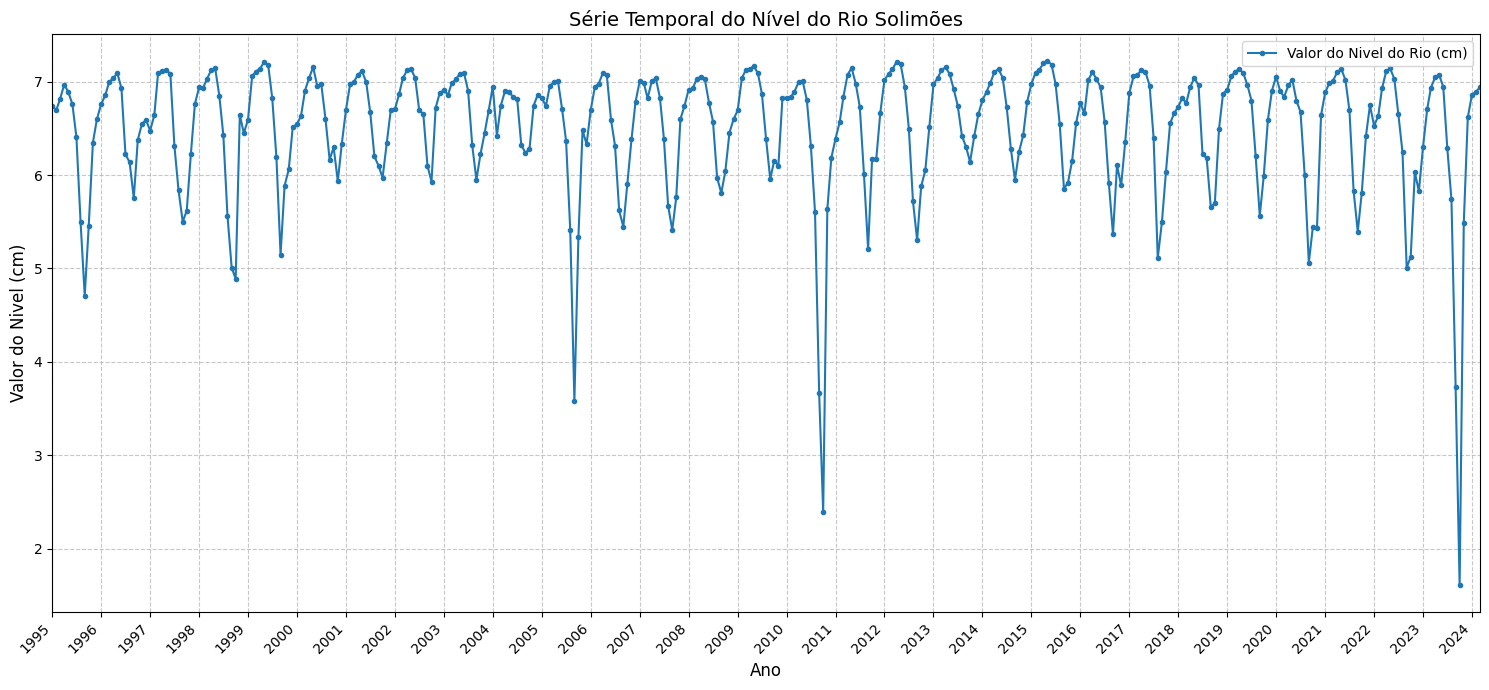

In [17]:
# --- 1. Preparação dos Dados (Exemplo) ---

# Certifique-se de que a coluna 'Data' está no formato datetime
#df['Data'] = pd.to_datetime(df['Data'])
# Ordene os dados pela data, caso não estejam
#df = df.sort_values(by='Data')
#df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')
# --- 2. Criação do Gráfico ---
fig, ax = plt.subplots(figsize=(15, 7)) # Ajuste o tamanho conforme necessário
# Plotar a série temporal completa (todos os pontos mensais)
dados_log = np.log(dados_final['nivel'])
ax.plot(dados_final.index, dados_log, marker='.', linestyle='-', label='Valor do Nivel do Rio (cm)')

# --- 3. Configuração do Eixo Horizontal (Apenas Anos) ---
# Definir o localizador principal para mostrar ticks no início de cada ano
ax.xaxis.set_major_locator(mdates.YearLocator())
# definir o ano de inicio do gráfico
ax.set_xlim(pd.to_datetime('1995-01-01'), pd.to_datetime('2024-03-01'))  # Ajuste o intervalo de datas conforme necessário

# Definir o formatador para mostrar apenas o ano "YYYY" (ex: 2020)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Opcional: se quiser ticks menores para os meses, sem rótulos
#ax.xaxis.set_minor_locator(mdates.MonthLocator())

# --- 4. Melhorias no Gráfico ---
ax.set_title('Série Temporal do Nível do Rio Solimões', fontsize=14)
ax.set_xlabel('Ano', fontsize=12)
ax.set_ylabel('Valor do Nivel (cm)', fontsize=12)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

# Rotacionar os rótulos do eixo X para melhor visualização (pode não ser necessário se forem poucos anos)
plt.xticks(rotation=45, ha='right')

# Ajustar o layout para evitar que os rótulos se sobreponham ou sejam cortados
plt.tight_layout()

# Mostrar o gráfico
plt.show()

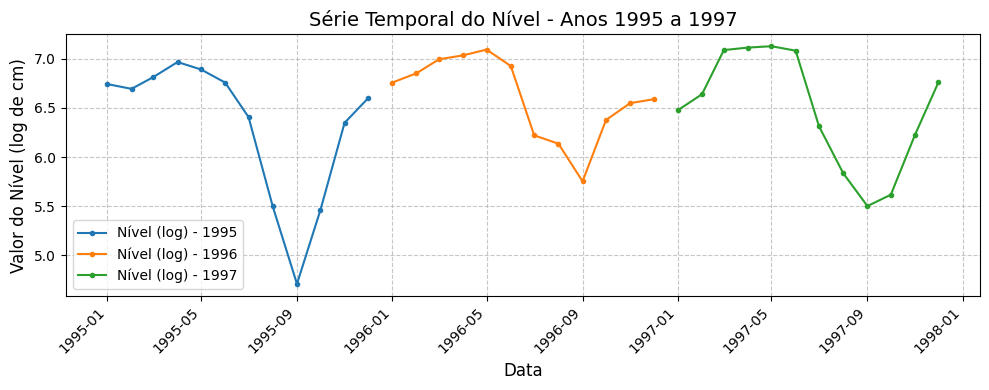

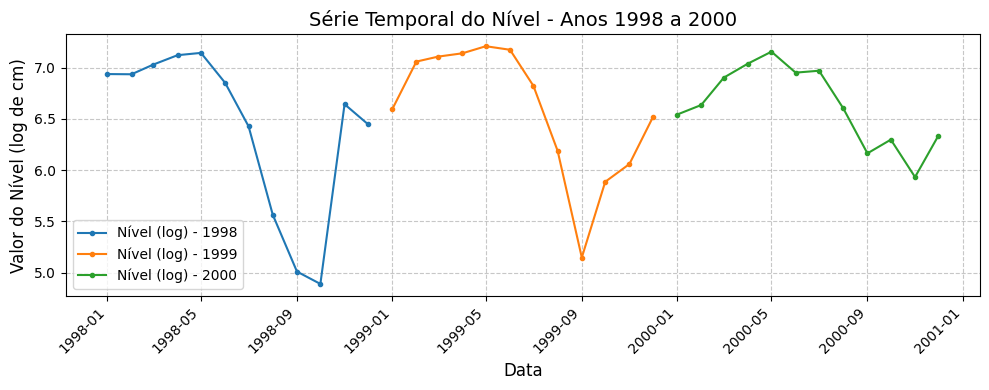

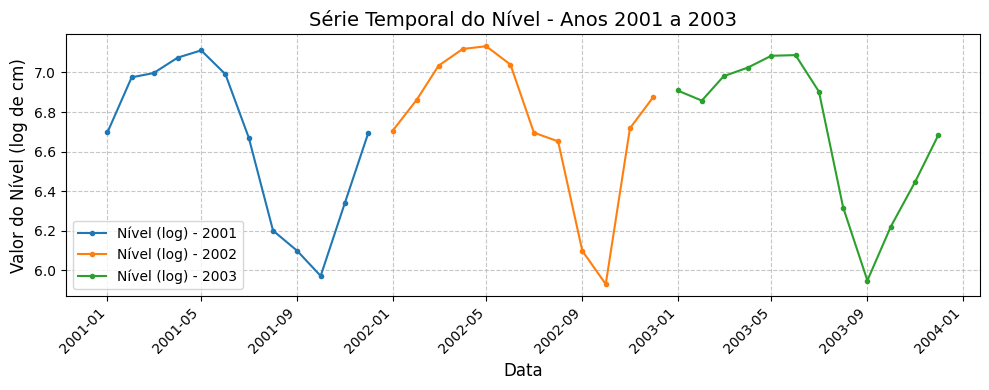

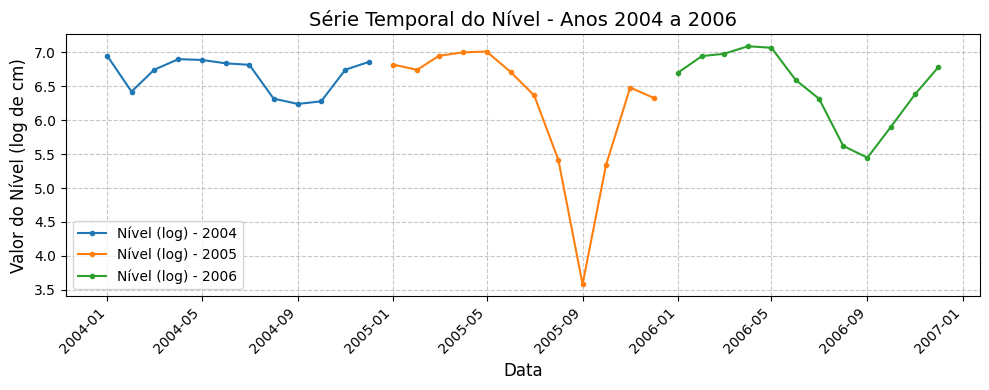

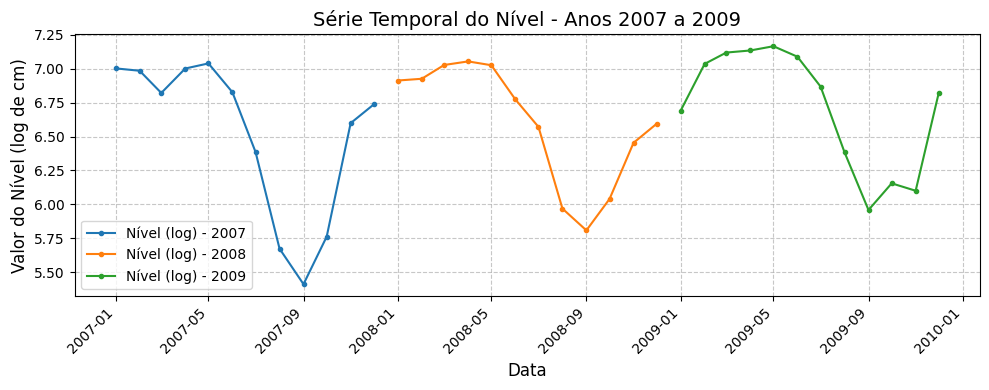

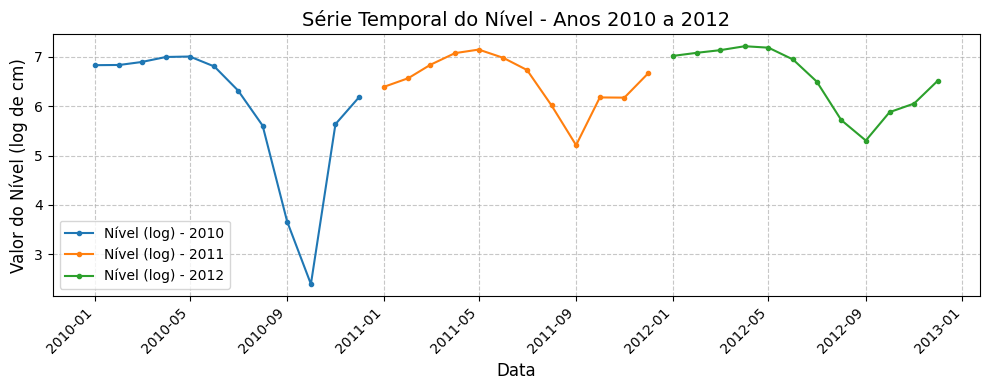

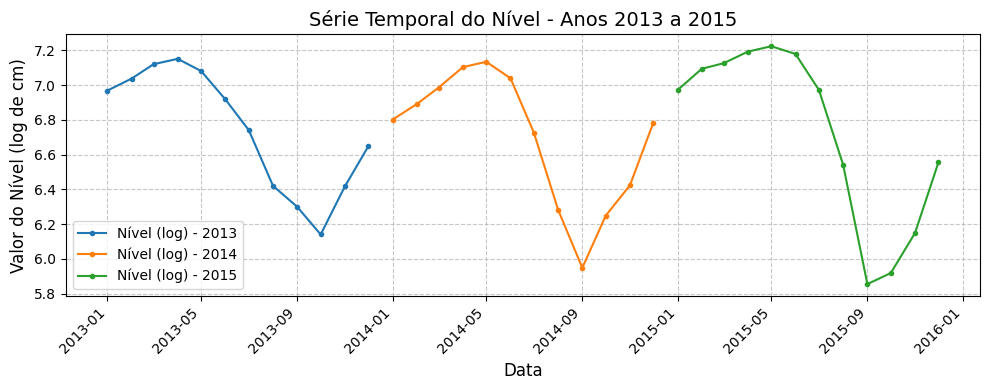

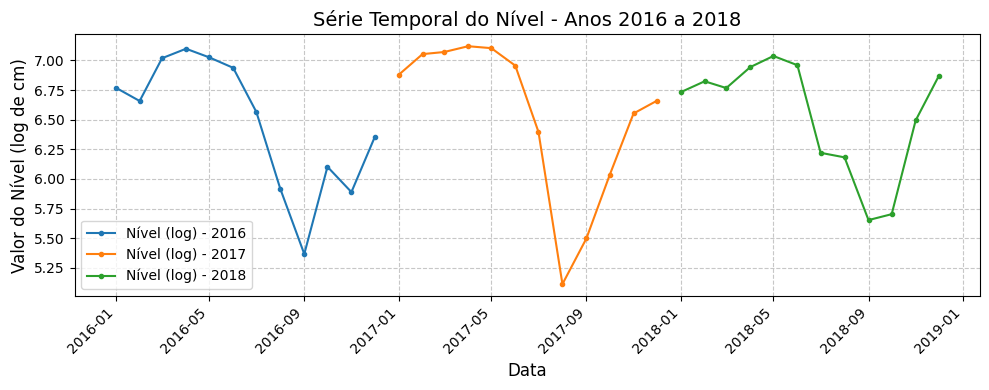

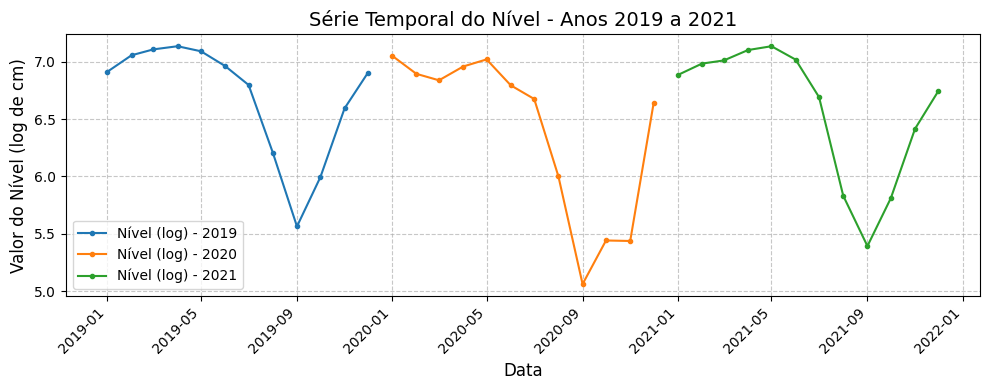

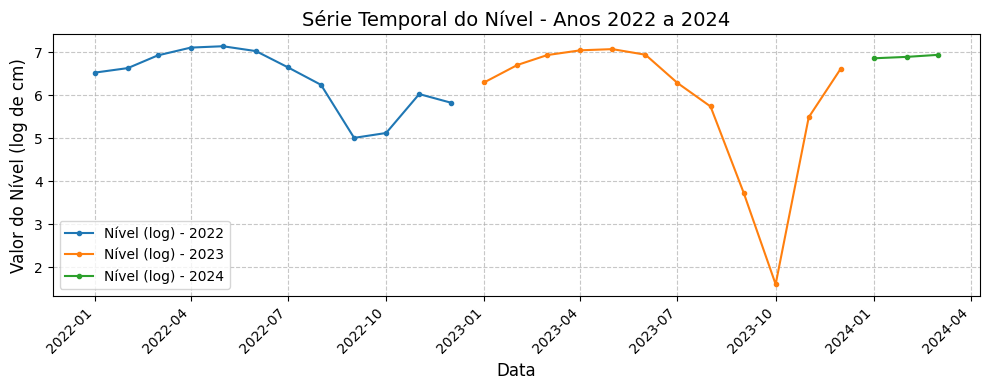

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Garante que os anos estejam em ordem para o agrupamento
anos_unicos = sorted(dados_final.index.year.unique())
n_anos = len(anos_unicos)

# Itera sobre a lista de anos em grupos de 3
for i in range(0, n_anos, 3):
    # Pega o grupo de anos (pode ter 1, 2 ou 3 anos)
    anos_grupo = anos_unicos[i:i+3]
    
    # Cria UMA figura para o grupo de anos
    plt.figure(figsize=(10, 4))
    
    # Loop interno para plotar cada ano do grupo na MESMA figura
    for ano in anos_grupo:
        # Filtra o DataFrame para o ano específico
        df_ano = dados_final[dados_final.index.year == ano]
        
        # Plota os dados de nível (log) para o ano atual
        plt.plot(df_ano.index, np.log(df_ano['nivel']), marker='.', linestyle='-', label=f'Nível (log) - {ano}')
    
    # --- Configurações aplicadas ao gráfico do GRUPO ---
    
    # Cria um título dinâmico para o grupo de anos
    if len(anos_grupo) > 1:
        plt.title(f'Série Temporal do Nível - Anos {anos_grupo[0]} a {anos_grupo[-1]}', fontsize=14)
    else:
        plt.title(f'Série Temporal do Nível - Ano {anos_grupo[0]}', fontsize=14)
        
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('Valor do Nível (log de cm)', fontsize=12)
    plt.legend() # A legenda é essencial aqui para diferenciar as linhas
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    
    # Mostra o gráfico com os 3 anos antes de ir para o próximo grupo
    plt.show()




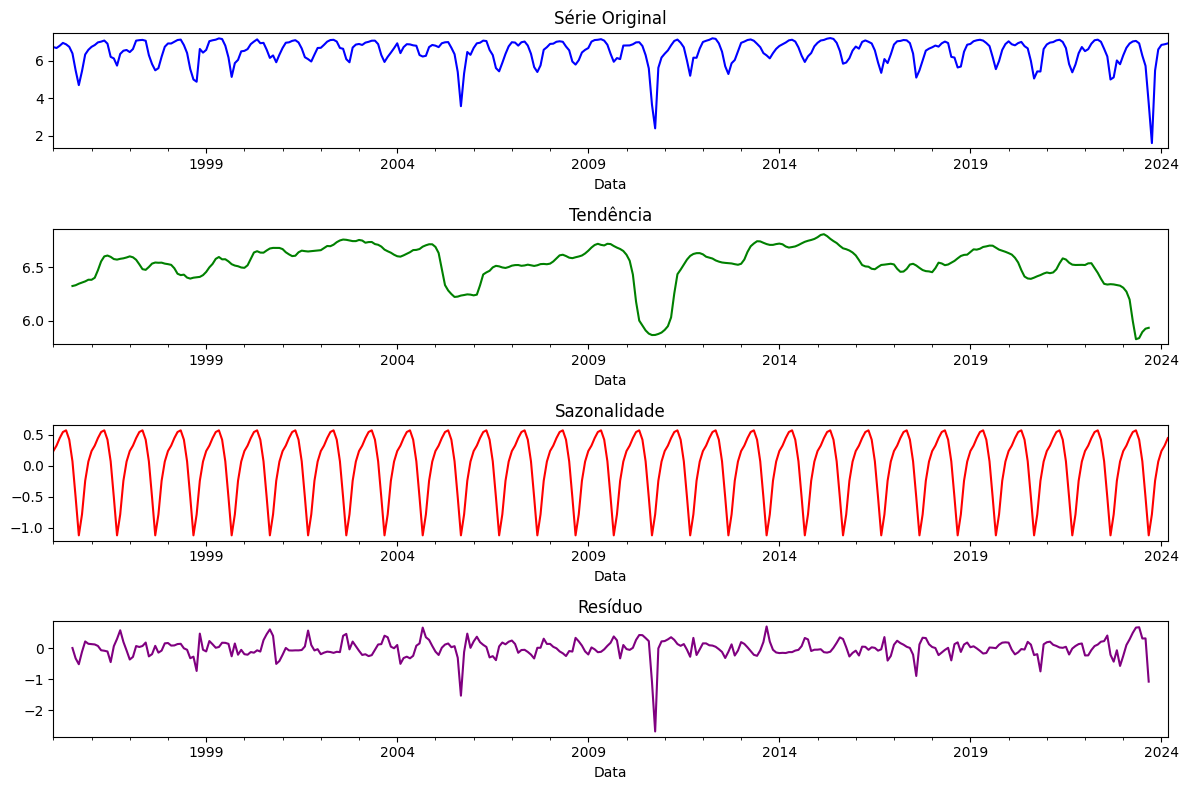

In [30]:
# decompor a série temporal em tendência, sazonalidade e resíduo e salvar essas series em variáveis diferentes

def decompor_serie(serie: pd.Series, periodo: int = 12, modelo: str = 'additive'):
    """
    Decompõe série temporal em 3 componentes:
    - tendência: padrão de longo prazo
    - sazonalidade: flutuações periódicas
    - resíduo: variação não explicada
    
    Parâmetros:
        periodo: ciclo sazonal (12 para mensal, 4 para trimestral)
        modelo: 'additive' (valores absolutos constantes) ou 'multiplicative' (valores relativos)
    """
    try:
        decomposicao = seasonal_decompose(
            serie.dropna(), 
            period=periodo, 
            model=modelo
        )
        
        componentes = {
            'original': serie,
            'tendencia': decomposicao.trend,
            'sazonalidade': decomposicao.seasonal,
            'residuo': decomposicao.resid
        }
        
        # Plotar componentes
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))
        
        componentes['original'].plot(ax=ax1, title='Série Original', color='blue')
        componentes['tendencia'].plot(ax=ax2, title='Tendência', color='green')
        componentes['sazonalidade'].plot(ax=ax3, title='Sazonalidade', color='red')
        componentes['residuo'].plot(ax=ax4, title='Resíduo', color='purple')
        
        plt.tight_layout()
        plt.show()
        
        return componentes
        
    except Exception as e:
        print(f"Erro: {str(e)}")
        print("Verifique: \n1. Série tem >=2 ciclos completos\n2. Modelo adequado (aditivo/multiplicativo)")
        return None



# Decompor e salvar componentes --------------------------------------------------
componentes = decompor_serie(np.log(dados_final['nivel']), periodo=12)

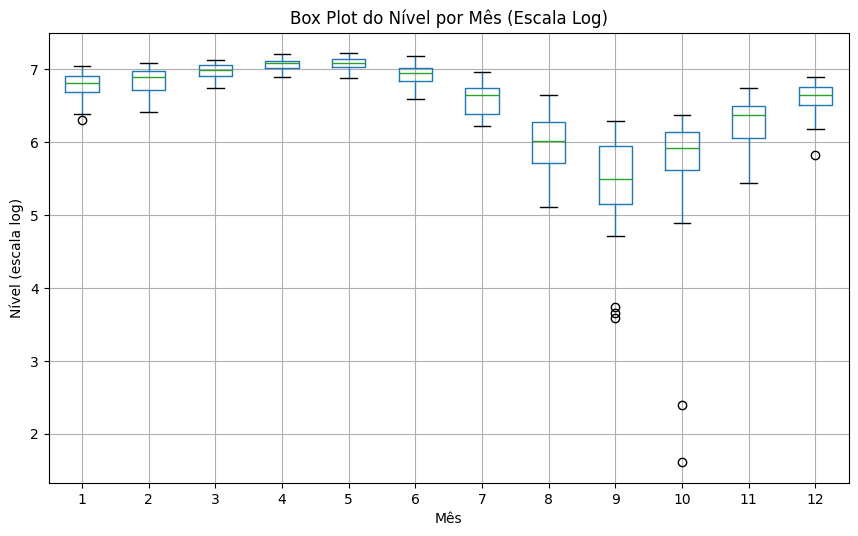

In [36]:
#Box-plot

# Cria a coluna 'Month' a partir do índice (correto)
dados_final['Month'] = dados_final.index.month

# --- CORREÇÃO APLICADA AQUI ---

# 1. Crie uma nova coluna com os dados transformados (log)
dados_final['nivel_log'] = np.log(dados_final['nivel'])

# 2. Chame o boxplot usando o NOME da nova coluna
dados_final.boxplot(column='nivel_log', by='Month', figsize=(10, 6))

# --- Ajustes de clareza nos rótulos ---
plt.title('Box Plot do Nível por Mês (Escala Log)')
plt.suptitle('')  # Remove o título automático gerado pelo pandas
plt.xlabel("Mês")
plt.ylabel("Nível (escala log)") # Rótulo do eixo Y reflete a transformação
plt.grid(True)
plt.show()


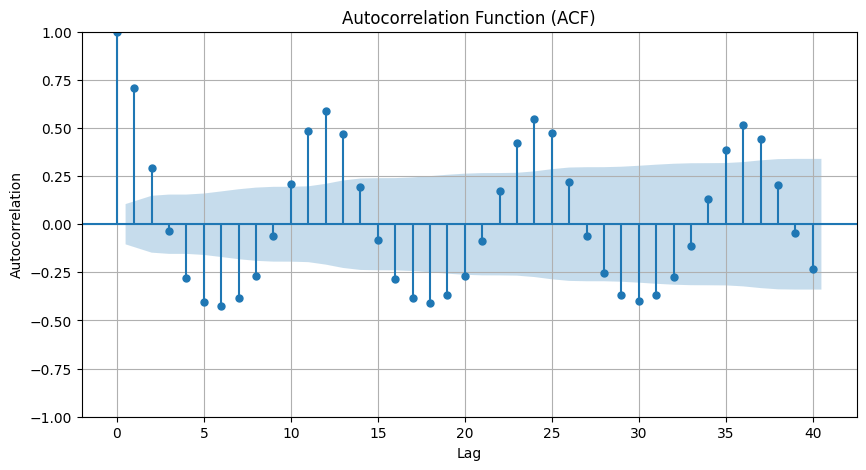

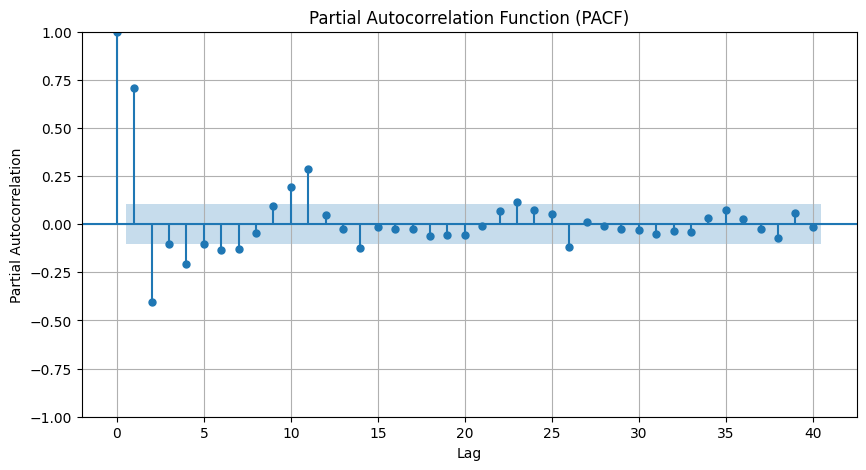

In [39]:
#Criando um gráfico de acf e pacf

#The ACF plot shows the correlation between a time series and its lagged values.
#The PACF plot shows the correlation between a time series and its lagged values, controlling for the correlations at intermediate lags.

# Create the ACF plot
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(dados_final['nivel_log'], lags=40, ax=ax)  # Adjust lags as needed
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid()
plt.show()

# Create the PACF plot
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(dados_final['nivel_log'], lags=40, ax=ax)  # Adjust lags as needed
plt.title("Partial Autocorrelation Function (PACF)")
plt.xlabel("Lag")
plt.ylabel("Partial Autocorrelation")
plt.grid()
plt.show()


In [44]:
#Teste para Sazonalidade

#Ho: NÃO apresenta sazonalidade
#Ha: Apresenta sazonalidade

from scipy.stats import kruskal


# Extraindo os meses dos dados
dados_final['Month'] = dados_final.index.month

mensal_media = [dados_final['nivel_log'][dados_final['Month'] == m] for m in range(1, 13)]

statistic, p_value = kruskal(*mensal_media)

# Apresente o Resultado
print(f"Kruskal-Wallis Statistic: {statistic}")
print(f"P-value: {p_value}")

# Interpretação
if p_value < 0.05:
    print("Existe evidência de sazonalidade na série.")
else:
    print("Não existe evidência de sazonalidade na série.")

Kruskal-Wallis Statistic: 289.03091352869785
P-value: 1.7870316281071564e-55
Existe evidência de sazonalidade na série.


In [ ]:
# realizar o teste de Dickey-Fuller aumentado (ADF) para verificar a estacionaridade da série temporal
teste_adf(dados_final['nivel_log'])

Teste de Dickey-Fuller Aumentado (nivel_log)
--------------------------------------------------
Estatística ADF: -3.4916
Valor-p: 0.0082

Valores Críticos:
1%: -3.4499
5%: -2.8702
10%: -2.5714

Conclusão:
Rejeitamos H0 (p=0.0082 < 0.05). Série ESTACIONÁRIA


In [46]:
# realizar teste Kwiatkowski Phillips Schimidt Shin(KPSS) para verificar a estacionaridade da série temporal
# Executar teste
teste_kpss(dados_final['nivel_log'])

Teste KPSS: nivel_log
Estatística KPSS: 0.1177
Valor-p: 0.1000
Número de lags: 7

Valores Críticos:
10%%: 0.3470
5%%: 0.4630
2.5%%: 0.5740
1%%: 0.7390

Hipóteses:
H0: A série é estacionária (não há raiz unitária)
H1: A série não é estacionária (presença de raiz unitária)

Conclusão:
Não rejeitamos H0 (p=0.1000 ≥ 0.05) → Série ESTACIONÁRIA


C:\Users\edfra\AppData\Local\Temp\ipykernel_22096\2167862661.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  estatistica, p_valor, n_lags, valores_criticos = kpss(serie.dropna(), regression='c', nlags='auto')


In [49]:
# 1) Endógena
endog = dados_final['nivel']

# 2) Exógenas
exog = dados_final[['vazao']]

# 3) Definição e ajuste do modelo
# Agora o código deve rodar sem erros, pois os dados estão limpos
model = sm.tsa.UnobservedComponents(
    endog,
    level='llevel',
    freq_seasonal=[{'period': 12, 'harmonics': 3}],
    cycle=True,
    exog=exog,
    irregular=True
)

resultado = model.fit(disp=False)
print(resultado.summary())


c:\Users\edfra\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"


                                Unobserved Components Results                                
Dep. Variable:                                 nivel   No. Observations:                  351
Model:                                   local level   Log Likelihood               -1628.476
                   + stochastic freq_seasonal(12(3))   AIC                           3266.951
                                             + cycle   BIC                           3286.125
Date:                               Thu, 24 Jul 2025   HQIC                          3274.590
Time:                                       21:21:49                                         
Sample:                                   01-01-1995                                         
                                        - 03-01-2024                                         
Covariance Type:                                 opg                                         
                                 coef    std err          z 

c:\Users\edfra\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [50]:
# 1) Endógena
endog = dados_final['nivel']

# 2) Exógenas
exog = dados_final[['vazao']]

# 3) Definição e ajuste do modelo
# Agora o código deve rodar sem erros, pois os dados estão limpos
model_simples = sm.tsa.UnobservedComponents(
    endog,
    level='llevel', # Mantém a tendência estocástica que foi significativa
    cycle=True,     # Mantém o ciclo que foi significativo
    exog=exog
)
resultado_simples = model_simples.fit(disp=False)
print(resultado_simples.summary())

                        Unobserved Components Results                         
Dep. Variable:                  nivel   No. Observations:                  351
Model:                    local level   Log Likelihood               -2344.662
                              + cycle   AIC                           4697.323
Date:                Thu, 24 Jul 2025   BIC                           4712.732
Time:                        21:22:02   HQIC                          4703.458
Sample:                    01-01-1995                                         
                         - 03-01-2024                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  8.922e+04   8.02e+04      1.113      0.266   -6.79e+04    2.46e+05
sigma2.level      3435.8430   2.93

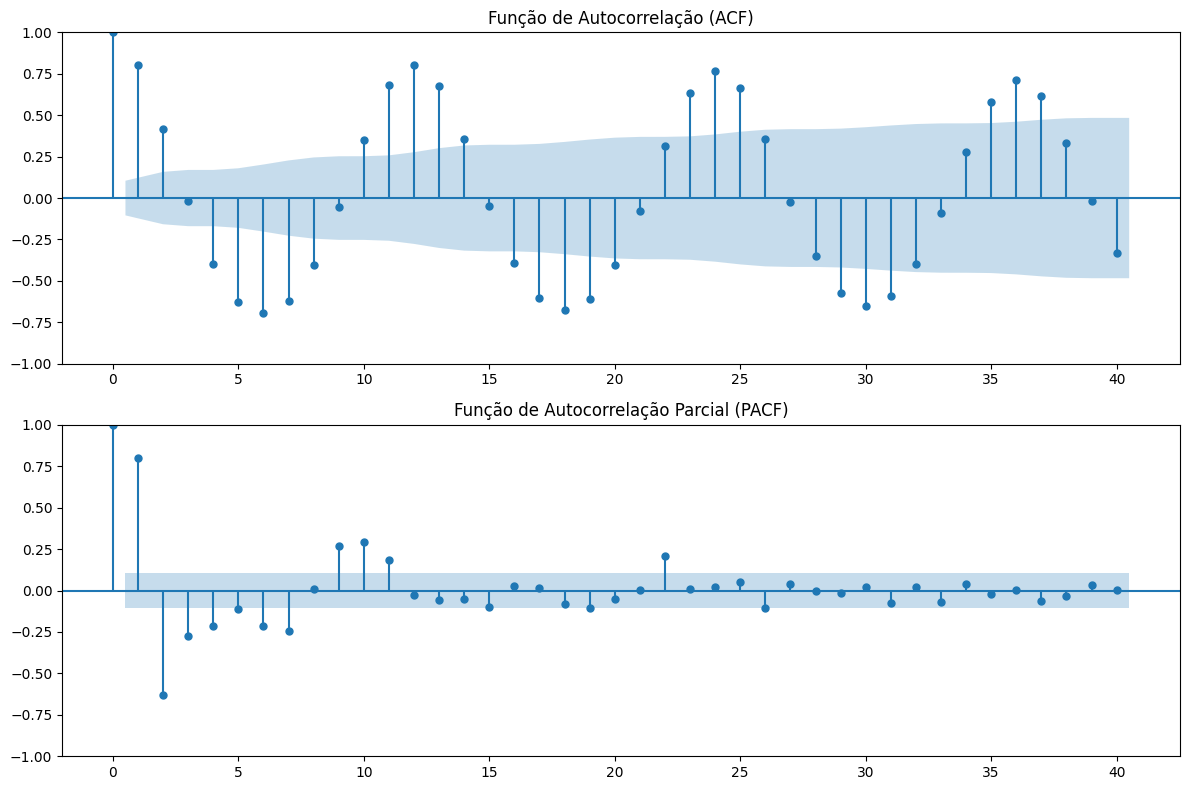

In [51]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Garanta que 'dados_final' e 'nivel' estejam definidos
endog = dados_final['nivel']

# Criar os gráficos ACF e PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Gráfico ACF
sm.graphics.tsa.plot_acf(endog, lags=40, ax=axes[0])
axes[0].set_title('Função de Autocorrelação (ACF)')

# Gráfico PACF
sm.graphics.tsa.plot_pacf(endog, lags=40, ax=axes[1])
axes[1].set_title('Função de Autocorrelação Parcial (PACF)')

plt.tight_layout()
plt.show()


In [52]:
# Assumindo que seus dados são mensais. Se não, ajuste o valor de 'seasonal'.
PERIODO_SAZONAL = 12 

# 1) Endógena e Exógena
endog = dados_final['nivel']
exog = dados_final[['vazao']]

# 2) Definição e ajuste do modelo com a configuração correta
# Este modelo representa: Nivel = Média Fixa + Sazonalidade + Efeito da Vazão + Ruído
model_uc_correto = sm.tsa.UnobservedComponents(
    endog,
    level='deterministic constant',  # CORRETO: para série estacionária
    seasonal=PERIODO_SAZONAL, # CORRETO: para capturar a sazonalidade encontrada
    cycle=True,
    exog=exog
    # Omitimos 'cycle=True' pois não foi significativo e a sazonalidade é mais específica
)

resultado_uc_correto = model_uc_correto.fit(disp=False)
print(resultado_uc_correto.summary())

                            Unobserved Components Results                            
Dep. Variable:                         nivel   No. Observations:                  351
Model:                deterministic constant   Log Likelihood               -1762.382
                   + stochastic seasonal(12)   AIC                           3532.763
                                     + cycle   BIC                           3548.044
Date:                       Thu, 24 Jul 2025   HQIC                          3538.854
Time:                               21:24:02                                         
Sample:                           01-01-1995                                         
                                - 03-01-2024                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

                                     SARIMAX Results                                      
Dep. Variable:                              nivel   No. Observations:                  351
Model:             SARIMAX(3, 0, 0)x(1, 1, 0, 12)   Log Likelihood               -1474.484
Date:                            Thu, 24 Jul 2025   AIC                           2960.967
Time:                                    21:24:25   BIC                           2983.652
Sample:                                01-01-1995   HQIC                          2970.021
                                     - 03-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vazao          0.0259      0.000     83.883      0.000       0.025       0.026
ar.L1          0.4707      0.036   

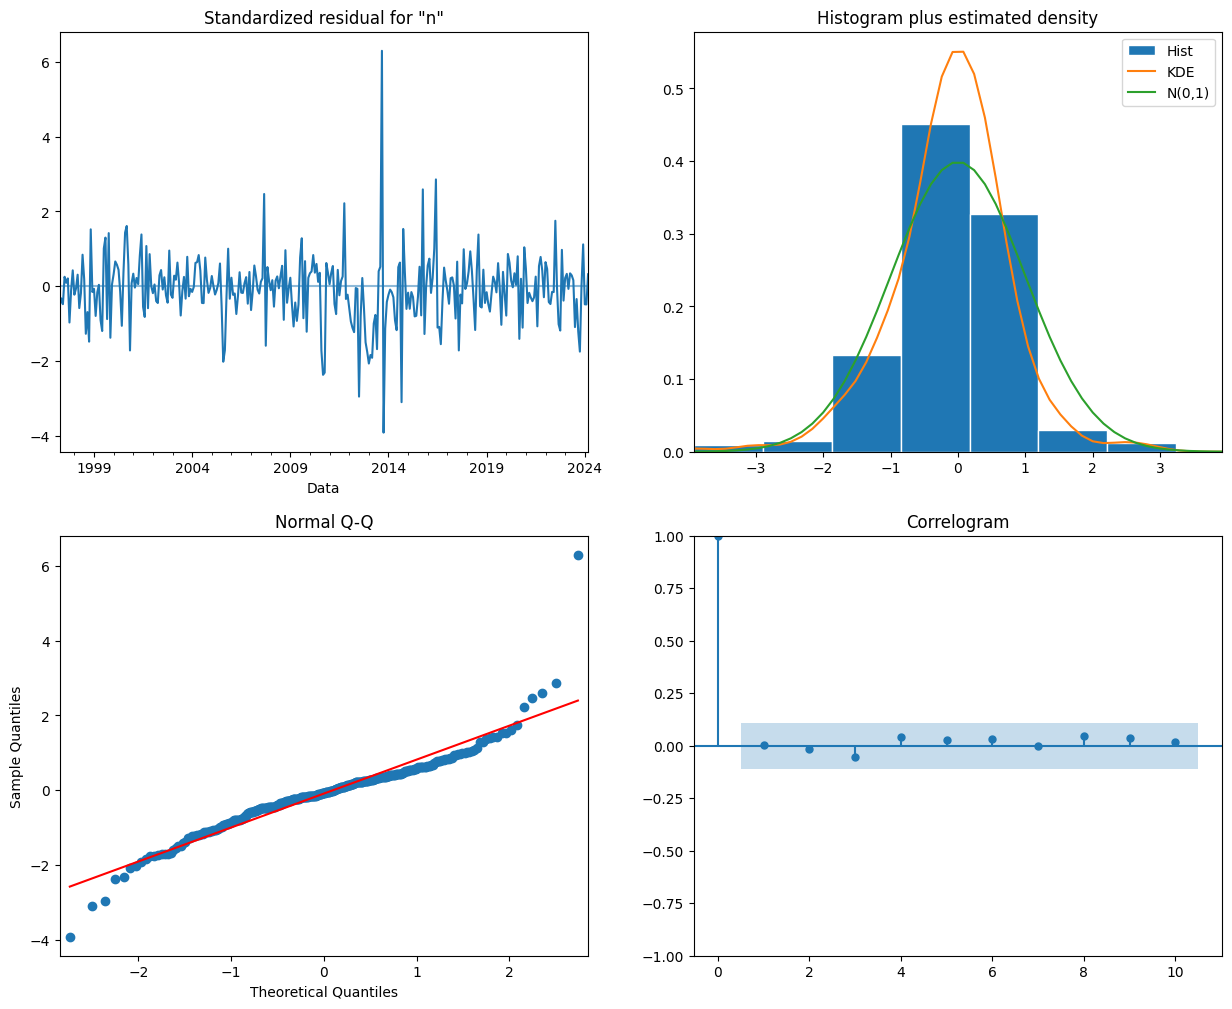

In [53]:
# 1) Endógena e Exógena
endog = dados_final['nivel']
exog = dados_final[['vazao']]

# 2) Definição e ajuste do modelo SARIMAX
# Assumindo sazonalidade mensal (m=12). Ajuste se for diferente.
model_sarimax = sm.tsa.SARIMAX(
    endog,
    exog=exog,
    order=(3, 0, 0),
    seasonal_order=(1, 1, 0, 12),
    enforce_stationarity=False, # Importante pois d=0
    enforce_invertibility=False
)

resultado_sarimax = model_sarimax.fit(disp=False)
print(resultado_sarimax.summary())

# 3) Verifique os diagnósticos. Queremos resíduos sem padrão!
resultado_sarimax.plot_diagnostics(figsize=(15, 12))
plt.show()


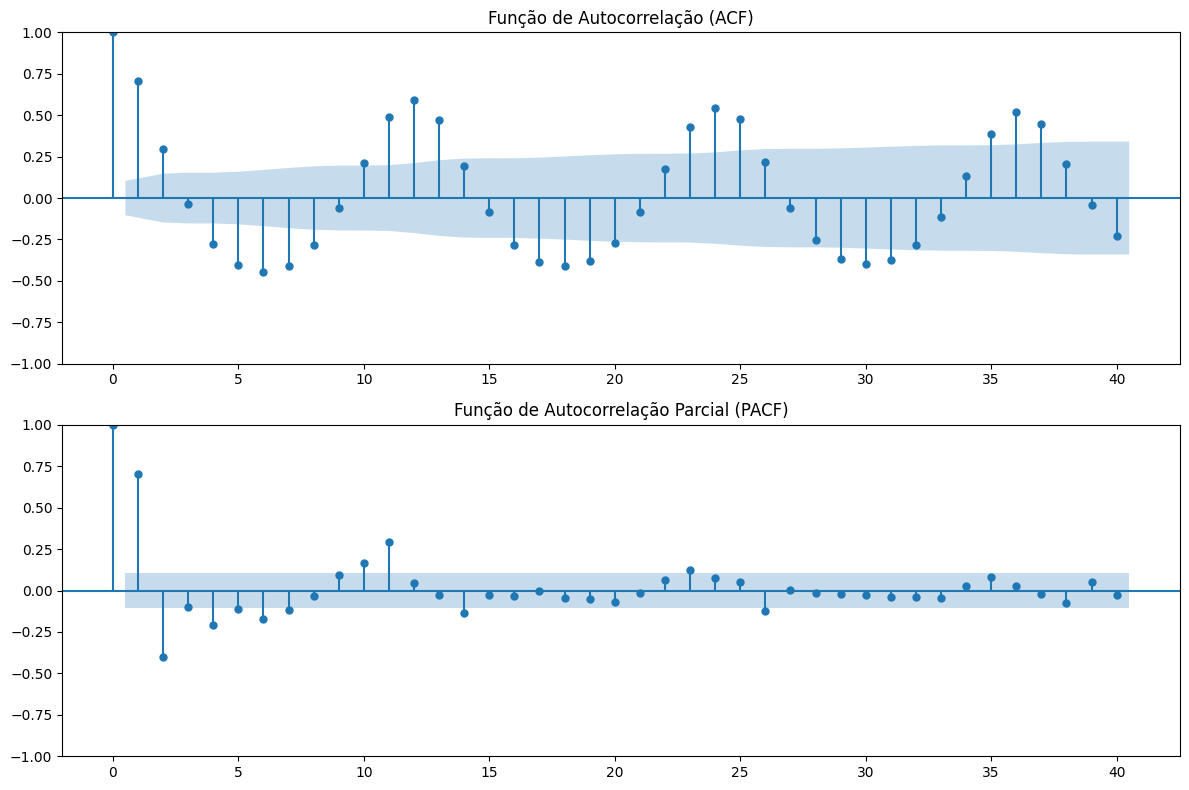

In [13]:
# Garanta que 'dados_final' e 'nivel' estejam definidos
endog = dados_final['nivel']
endog_log = np.log(endog)

# Criar os gráficos ACF e PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Gráfico ACF
sm.graphics.tsa.plot_acf(endog_log, lags=40, ax=axes[0])
axes[0].set_title('Função de Autocorrelação (ACF)')

# Gráfico PACF
sm.graphics.tsa.plot_pacf(endog_log, lags=40, ax=axes[1])
axes[1].set_title('Função de Autocorrelação Parcial (PACF)')

plt.tight_layout()
plt.show()


                                     SARIMAX Results                                      
Dep. Variable:                              nivel   No. Observations:                  355
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                -105.351
Date:                            Tue, 22 Jul 2025   AIC                            218.703
Time:                                    20:57:33   BIC                            233.899
Sample:                                01-01-1995   HQIC                           224.764
                                     - 07-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vazao       4.661e-05      5e-06      9.321      0.000    3.68e-05    5.64e-05
ar.L1          0.4288      0.019   

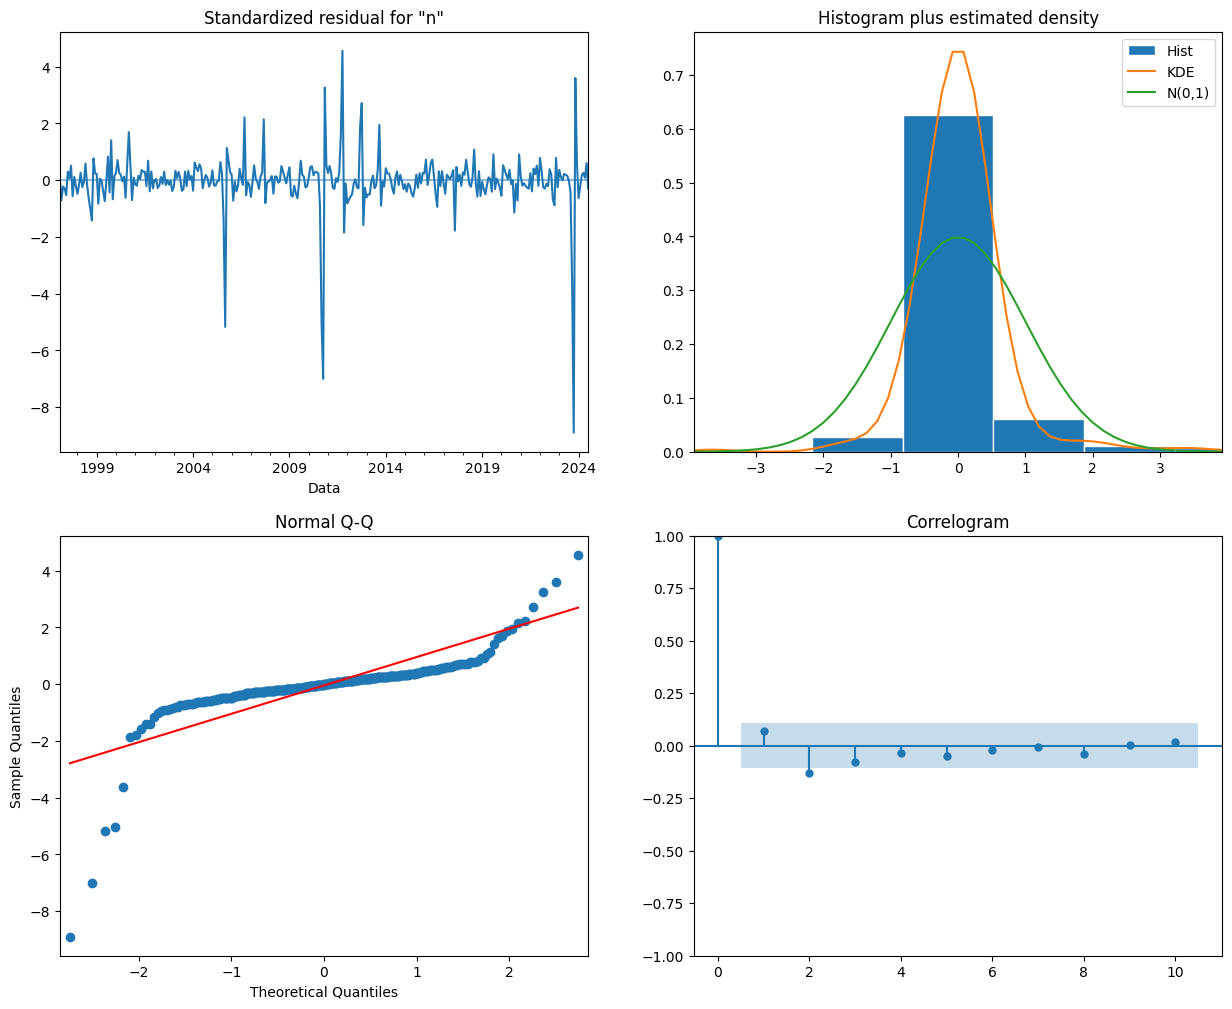

In [16]:


# Seus dados endog e exog já estão definidos
endog = dados_final['nivel']
endog_log = np.log(endog)
exog = dados_final[['vazao']]

# Definir e ajustar o modelo SARIMAX REFINADO
# Ordem: (p=1, d=0, q=0)
# Ordem Sazonal: (P=1, D=1, Q=0, m=12)
model_sarimax_log = sm.tsa.SARIMAX(
    endog_log,
    exog=exog,
    order=(1, 0, 0),
    seasonal_order=(1, 1, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_sarimax_log = model_sarimax_log.fit(method='powell', disp=False)
print(results_sarimax_log.summary())

# Diagnóstico dos resíduos do novo modelo
results_sarimax_log.plot_diagnostics(figsize=(15, 12))
plt.show()

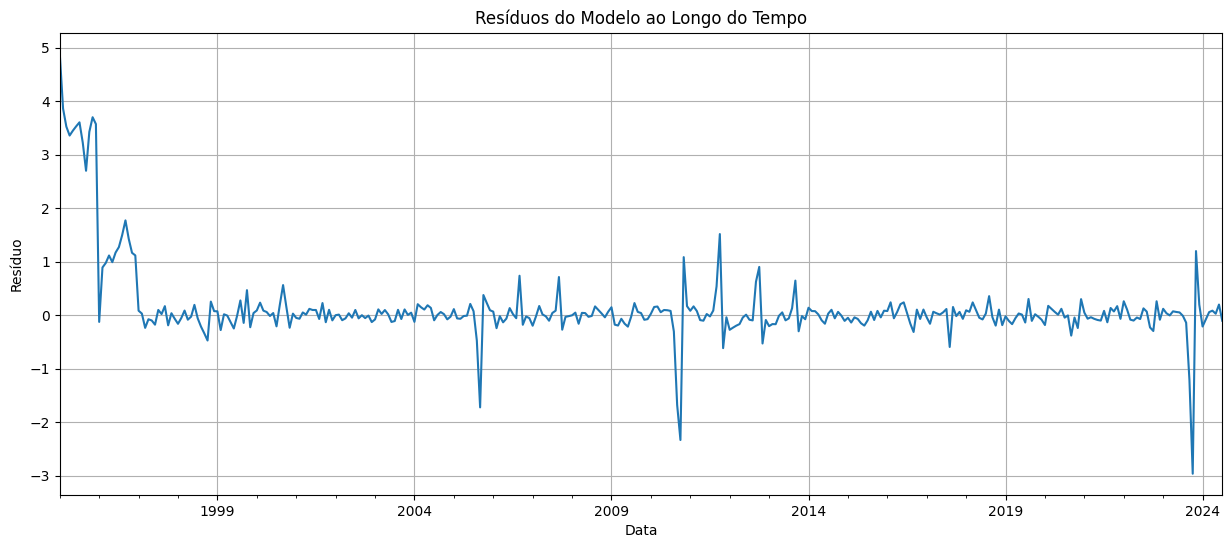

In [17]:
# Você também pode plotar os resíduos diretamente para ver melhor
results_sarimax_log.resid.plot(figsize=(15, 6))
plt.title('Resíduos do Modelo ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Resíduo')
plt.grid(True)
plt.show()

In [18]:
# Supondo que 'results_sarimax_log' seja o resultado do seu modelo ajustado

# 1. Extrair os resíduos do modelo
residuos = results_sarimax_log.resid

# 2. Padronizar os resíduos (Média 0, Desvio Padrão 1)
# Isso é exatamente o que o gráfico "Standardized Residuals" mostra
residuos_padronizados = (residuos - residuos.mean()) / residuos.std()

# 3. Definir nosso limite. Um valor entre 2.5 e 3.5 é geralmente bom.
# Valores acima disso são outliers muito prováveis.
limite = 3.0

# 4. Filtrar para encontrar os resíduos que ultrapassam o limite (tanto positivos quanto negativos)
outliers = residuos_padronizados[abs(residuos_padronizados) > limite]

# 5. Ordenar os outliers pelos piores (maior valor absoluto) e exibi-los
if outliers.empty:
    print(f"Boas notícias! Nenhum outlier encontrado acima do limite de {limite} desvios padrão.")
else:
    print(f"--- Outliers Identificados (limite > {limite} desvios padrão) ---")
    # Ordena para mostrar os mais extremos primeiro
    outliers_ordenados = outliers.abs().sort_values(ascending=False)
    print("Os piores outliers (data e valor do resíduo padronizado) são:")
    print(outliers.loc[outliers_ordenados.index])



--- Outliers Identificados (limite > 3.0 desvios padrão) ---
Os piores outliers (data e valor do resíduo padronizado) são:
Data
1995-01-01    6.279225
1995-02-01    4.922740
1995-11-01    4.707983
1995-07-01    4.581973
1995-12-01    4.538716
1995-06-01    4.483548
1995-03-01    4.475766
1995-05-01    4.377240
1995-10-01    4.346809
1995-04-01    4.255225
2023-10-01   -4.111918
1995-08-01    4.078662
1995-09-01    3.383646
2010-10-01   -3.277560
dtype: float64


In [19]:
# --- PASSO 1: Preparar o DataFrame para as Dummies ---

# É uma boa prática criar uma cópia para não alterar o DataFrame original
exog_com_dummies = exog.copy()

# --- PASSO 2: Criar a dummy para o ano de 1995 ---

# Primeiro, criamos uma coluna 'dummy_1995' e a preenchemos com 0
exog_com_dummies['dummy_1995'] = 0

# Agora, usamos a indexação de data do pandas para marcar todo o período de 1995 com o valor 1
# Isso é mais eficiente do que marcar cada data individualmente
exog_com_dummies.loc['1995-01-01':'1995-12-31', 'dummy_1995'] = 1

# --- PASSO 3: Criar as dummies para os outliers isolados ---

# Outlier de 2010
data_outlier_2010 = '2010-10-01'
exog_com_dummies[f'outlier_{data_outlier_2010}'] = 0
exog_com_dummies.loc[data_outlier_2010, f'outlier_{data_outlier_2010}'] = 1

# Outlier de 2023
data_outlier_2023 = '2023-10-01'
exog_com_dummies[f'outlier_{data_outlier_2023}'] = 0
exog_com_dummies.loc[data_outlier_2023, f'outlier_{data_outlier_2023}'] = 1

print("DataFrame exog com as novas dummies (primeiras e últimas linhas):")
print(exog_com_dummies.head())
print("\n")
print(exog_com_dummies.tail())
print("\nVerificando se as dummies foram criadas corretamente:")
print(exog_com_dummies.loc[['1995-03-01', '2010-10-01', '2023-10-01']])





DataFrame exog com as novas dummies (primeiras e últimas linhas):
                vazao  dummy_1995  outlier_2010-10-01  outlier_2023-10-01
Data                                                                     
1995-01-01  39711.438           1                   0                   0
1995-02-01  38174.215           1                   0                   0
1995-03-01  42288.590           1                   0                   0
1995-04-01  48282.215           1                   0                   0
1995-05-01  45118.850           1                   0                   0


                vazao  dummy_1995  outlier_2010-10-01  outlier_2023-10-01
Data                                                                     
2024-03-01  50581.240           0                   0                   0
2024-04-01  55600.926           0                   0                   0
2024-05-01  57018.840           0                   0                   0
2024-06-01  41388.980           0           


--- Ajustando o novo modelo com as dummies ---
                                     SARIMAX Results                                      
Dep. Variable:                              nivel   No. Observations:                  355
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                  32.664
Date:                            Tue, 22 Jul 2025   AIC                            -51.328
Time:                                    21:14:36   BIC                            -24.735
Sample:                                01-01-1995   HQIC                           -40.720
                                     - 07-01-2024                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
vazao               4.246e-05   2.93e-06     14.49

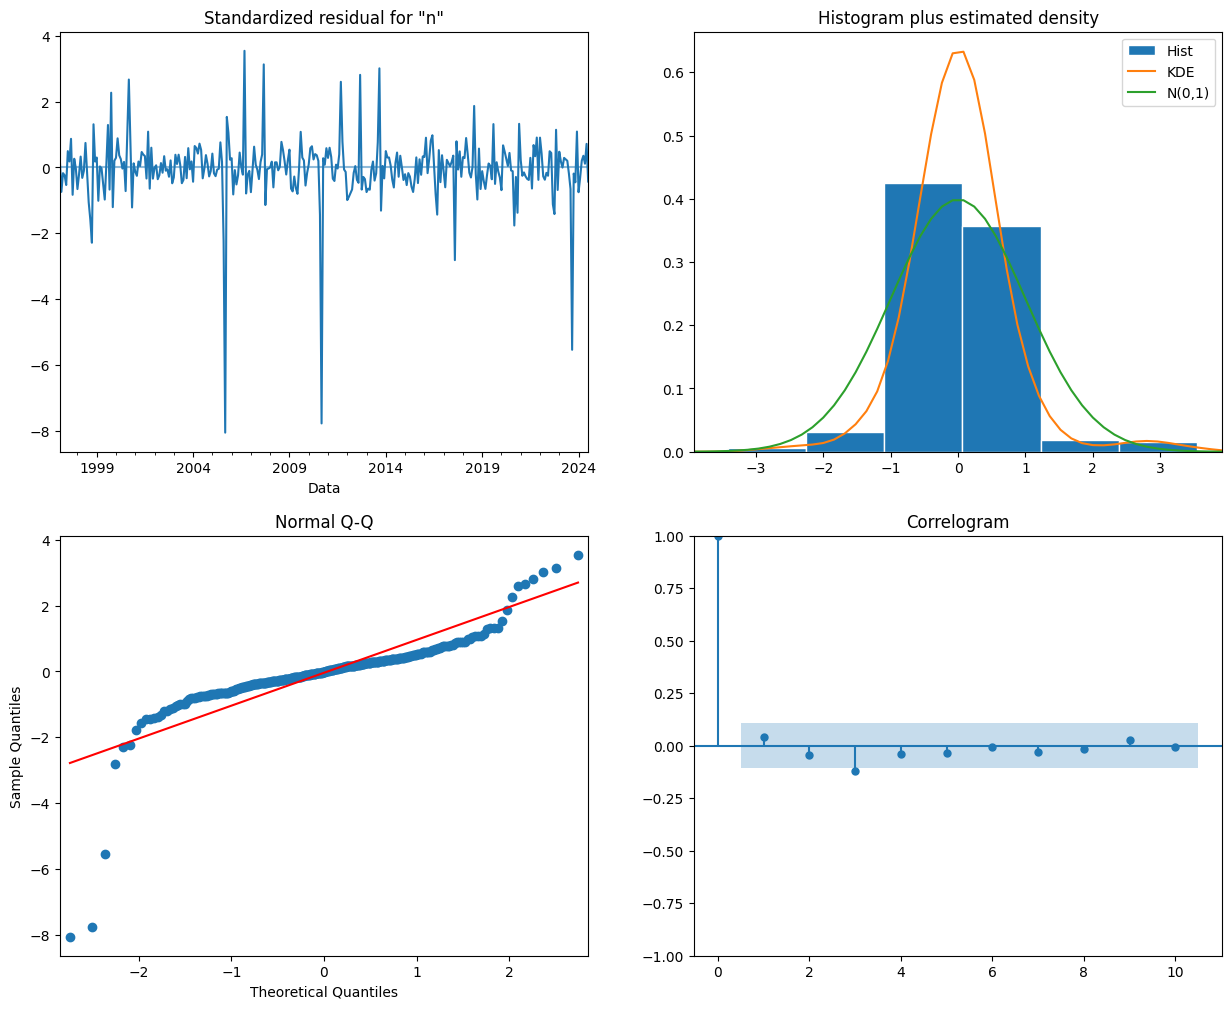

In [20]:
# --- PASSO 4: Reajustar o modelo SARIMAX com o novo exog ---

print("\n--- Ajustando o novo modelo com as dummies ---")

# Usamos o 'exog_com_dummies' que agora contém a vazão e nossas 3 novas variáveis
model_final = sm.tsa.SARIMAX(
    endog_log,
    exog=exog_com_dummies,
    order=(1, 0, 0),
    seasonal_order=(1, 1, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Continuamos usando 'powell' pois ele funcionou bem
results_final = model_final.fit(method='powell', disp=False)

# Imprimir o novo sumário
print(results_final.summary())

# --- PASSO 5: Verificar o novo diagnóstico dos resíduos ---
print("\n--- Gerando novo diagnóstico dos resíduos ---")
results_final.plot_diagnostics(figsize=(15, 12))
plt.show()


In [21]:
# --- PASSO 1: Preparar o DataFrame para as Dummies (versão refinada) ---
exog_refinado = exog.copy()

# --- PASSO 2: Manter as dummies que funcionaram ---
# Outlier de 2010
data_outlier_2010 = '2010-10-01'
exog_refinado[f'outlier_{data_outlier_2010}'] = 0
exog_refinado.loc[data_outlier_2010, f'outlier_{data_outlier_2010}'] = 1

# Outlier de 2023
data_outlier_2023 = '2023-10-01'
exog_refinado[f'outlier_{data_outlier_2023}'] = 0
exog_refinado.loc[data_outlier_2023, f'outlier_{data_outlier_2023}'] = 1

# --- PASSO 3: Adicionar dummies individuais para os piores outliers de 1995 ---
# Com base na sua lista, vamos pegar os 5 piores (com maior valor absoluto)
datas_outliers_1995 = [
    '1995-01-01',
    '1995-02-01',
    '1995-11-01',
    '1995-07-01',
    '1995-12-01'
]

for data in datas_outliers_1995:
    exog_refinado[f'outlier_{data}'] = 0
    exog_refinado.loc[data, f'outlier_{data}'] = 1

print("DataFrame exog com as dummies refinadas:")
print(exog_refinado.info()) # .info() é ótimo para ver todas as colunas criadas




DataFrame exog com as dummies refinadas:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 355 entries, 1995-01-01 to 2024-07-01
Freq: MS
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   vazao               355 non-null    float64
 1   outlier_2010-10-01  355 non-null    int64  
 2   outlier_2023-10-01  355 non-null    int64  
 3   outlier_1995-01-01  355 non-null    int64  
 4   outlier_1995-02-01  355 non-null    int64  
 5   outlier_1995-11-01  355 non-null    int64  
 6   outlier_1995-07-01  355 non-null    int64  
 7   outlier_1995-12-01  355 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 33.1 KB
None



--- Ajustando o modelo final com dummies refinadas ---
                                     SARIMAX Results                                      
Dep. Variable:                              nivel   No. Observations:                  355
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                  33.040
Date:                            Tue, 22 Jul 2025   AIC                            -44.080
Time:                                    21:19:24   BIC                             -2.290
Sample:                                01-01-1995   HQIC                           -27.411
                                     - 07-01-2024                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
vazao               4.268e-05   2.93e-06  

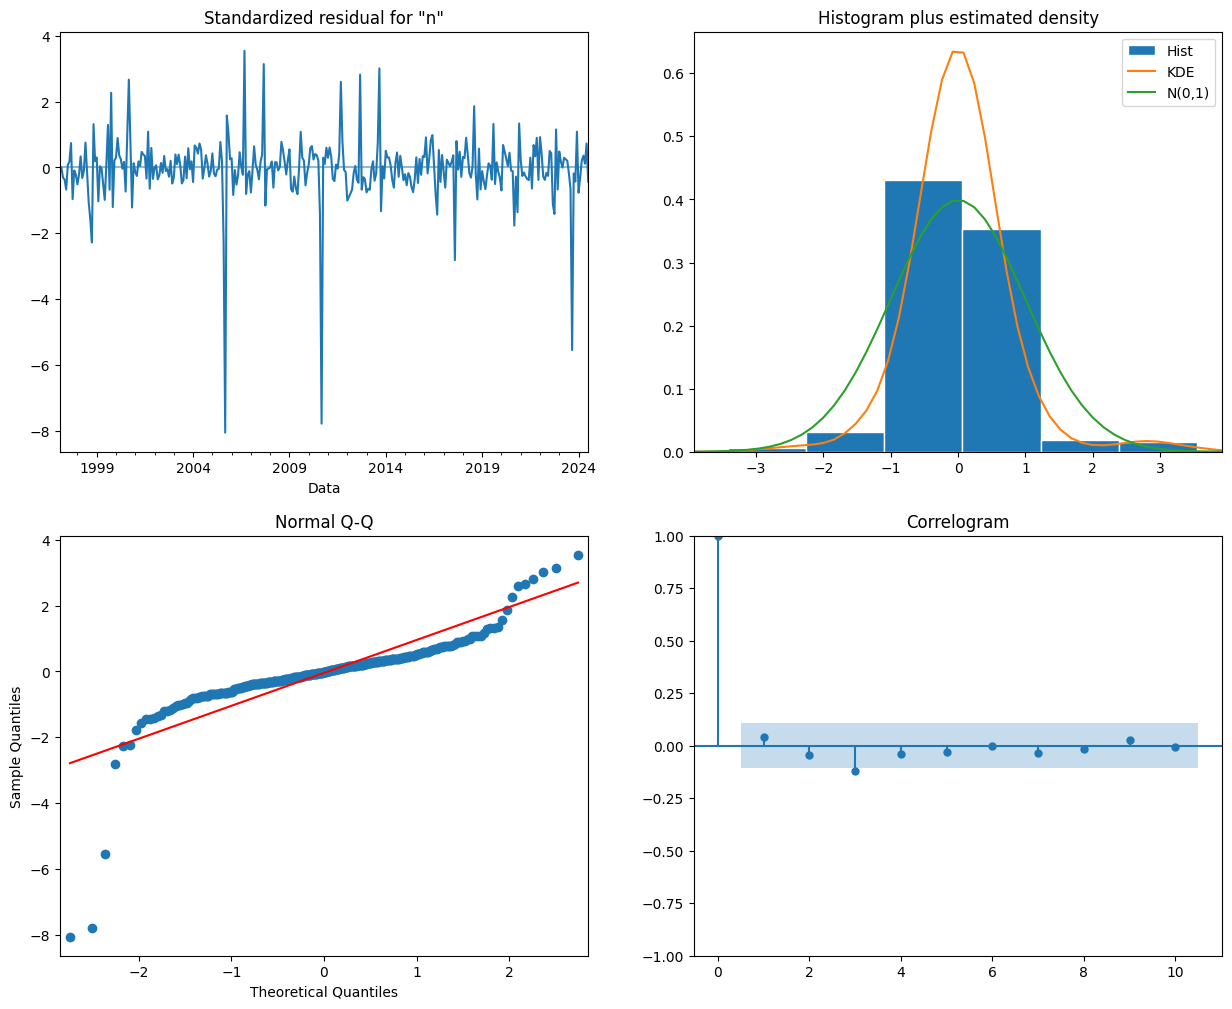

In [22]:
# --- PASSO 4: Reajustar o modelo SARIMAX final ---
print("\n--- Ajustando o modelo final com dummies refinadas ---")

model_final_refinado = sm.tsa.SARIMAX(
    endog_log,
    exog=exog_refinado,
    order=(1, 0, 0),
    seasonal_order=(1, 1, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_final_refinado = model_final_refinado.fit(method='powell', disp=False)

print(results_final_refinado.summary())

# --- PASSO 5: Diagnóstico final dos resíduos ---
print("\n--- Gerando diagnóstico final dos resíduos ---")
results_final_refinado.plot_diagnostics(figsize=(15, 12))
plt.show()

In [23]:
# --- PASSO 1: Preparar o DataFrame para o modelo final e parsimonioso ---
exog_final = exog.copy()

# --- PASSO 2: Adicionar as 4 dummies que se provaram significativas ---

# Outliers isolados de 2010 e 2023
exog_final['outlier_2010-10-01'] = 0
exog_final.loc['2010-10-01', 'outlier_2010-10-01'] = 1

exog_final['outlier_2023-10-01'] = 0
exog_final.loc['2023-10-01', 'outlier_2023-10-01'] = 1

# Outliers significativos de 1995
datas_outliers_1995_final = ['1995-01-01', '1995-02-01']
for data in datas_outliers_1995_final:
    exog_final[f'outlier_{data}'] = 0
    exog_final.loc[data, f'outlier_{data}'] = 1

print("DataFrame exog para o modelo final:")
print(exog_final.info())



DataFrame exog para o modelo final:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 355 entries, 1995-01-01 to 2024-07-01
Freq: MS
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   vazao               355 non-null    float64
 1   outlier_2010-10-01  355 non-null    int64  
 2   outlier_2023-10-01  355 non-null    int64  
 3   outlier_1995-01-01  355 non-null    int64  
 4   outlier_1995-02-01  355 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 24.7 KB
None



--- Ajustando o modelo CAMPEÃO (final e parsimonioso) ---
                                     SARIMAX Results                                      
Dep. Variable:                              nivel   No. Observations:                  355
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                  32.960
Date:                            Tue, 22 Jul 2025   AIC                            -49.919
Time:                                    21:24:33   BIC                            -19.527
Sample:                                01-01-1995   HQIC                           -37.796
                                     - 07-01-2024                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
vazao               4.264e-05   2.93e-0

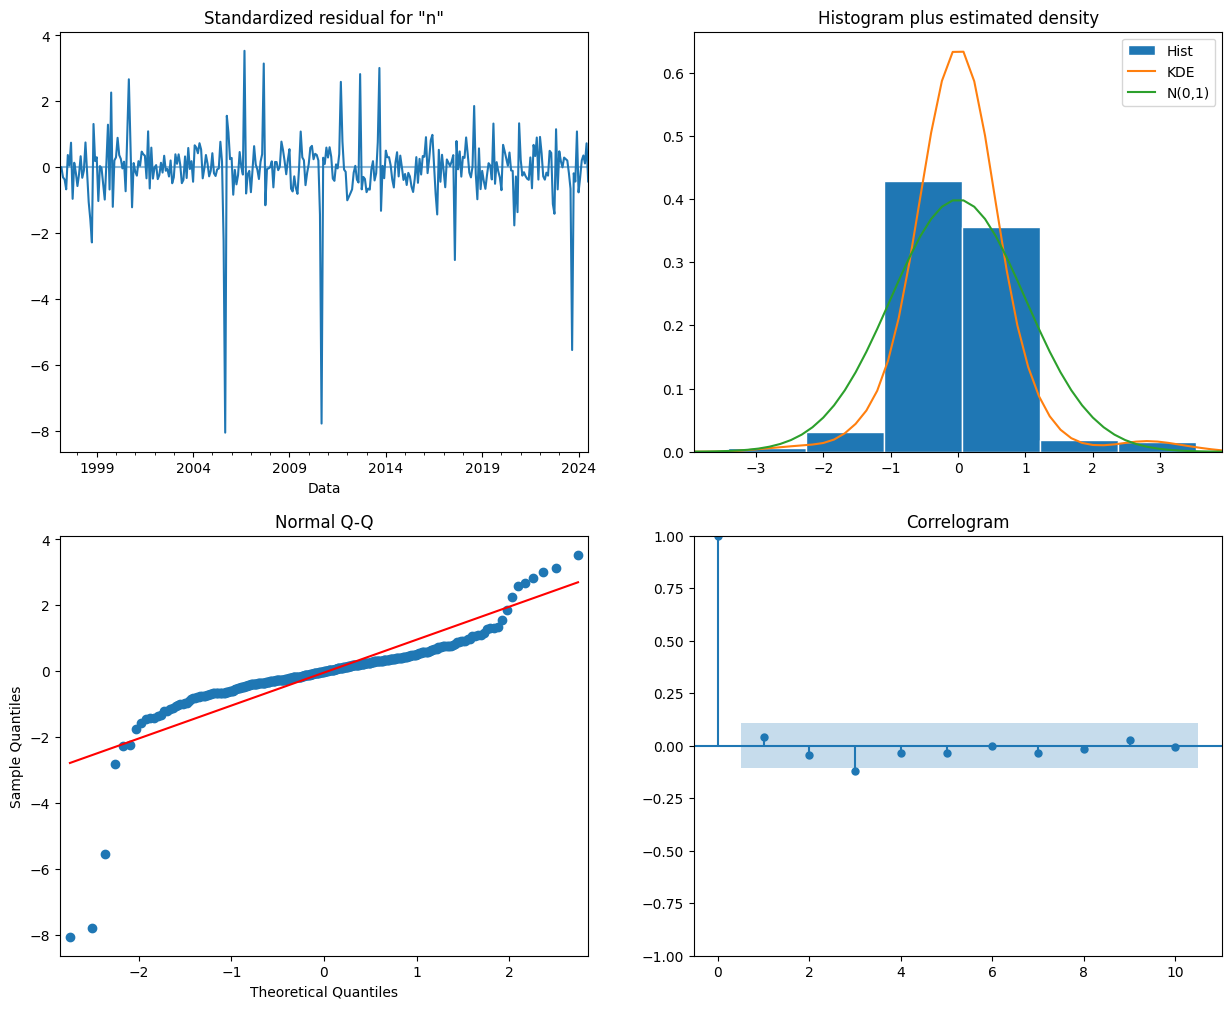

In [24]:
# --- PASSO 3: Ajustar o modelo SARIMAX final ---
print("\n--- Ajustando o modelo CAMPEÃO (final e parsimonioso) ---")

# Note que a estrutura do modelo (ordens) não mudou, apenas o exog
model_campeao = sm.tsa.SARIMAX(
    endog_log,
    exog=exog_final,
    order=(1, 0, 0),
    seasonal_order=(1, 1, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_campeao = model_campeao.fit(method='powell', disp=False)

print(results_campeao.summary())

# --- PASSO 4: Diagnóstico dos resíduos do modelo final ---
print("\n--- Gerando diagnóstico final dos resíduos ---")
results_campeao.plot_diagnostics(figsize=(15, 12))
plt.show()


Exog para o período de previsão:
                vazao  outlier_2010-10-01  outlier_2023-10-01  \
2024-08-01  36891.562                   0                   0   
2024-09-01  36891.562                   0                   0   
2024-10-01  36891.562                   0                   0   
2024-11-01  36891.562                   0                   0   
2024-12-01  36891.562                   0                   0   
2025-01-01  36891.562                   0                   0   
2025-02-01  36891.562                   0                   0   
2025-03-01  36891.562                   0                   0   
2025-04-01  36891.562                   0                   0   
2025-05-01  36891.562                   0                   0   
2025-06-01  36891.562                   0                   0   
2025-07-01  36891.562                   0                   0   

            outlier_1995-01-01  outlier_1995-02-01  
2024-08-01                   0                   0  
2024-09-01     

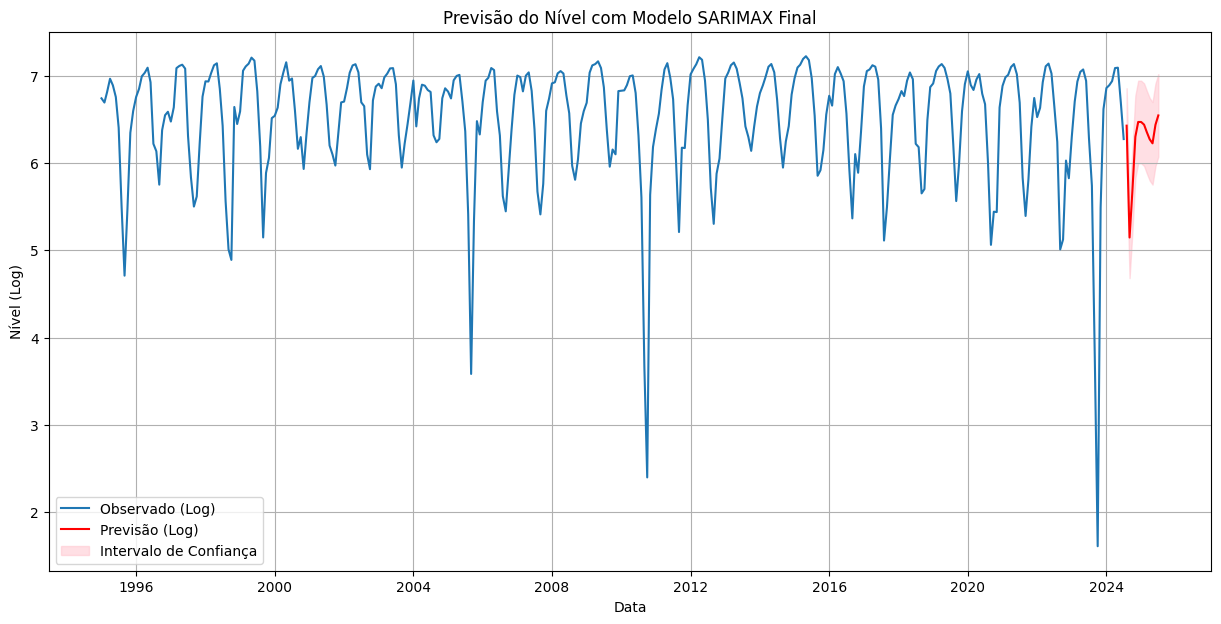

In [26]:
# --- PASSO FINAL: Gerando Previsões com o Modelo Campeão ---

# 1. Definir o número de passos à frente para a previsão
n_steps = 12 # Prever os próximos 12 meses

# 2. Criar o DataFrame 'exog' para o período futuro
# O modelo precisa dos valores de 'vazao' e das dummies para o futuro.
# Vamos assumir que a vazão futura seguirá uma média ou um valor específico.
# E que não haverá outliers (dummies = 0).

# Crie o índice de datas futuras
future_dates = pd.date_range(start=endog_log.index[-1] + pd.DateOffset(months=1), periods=n_steps, freq='MS')

# Crie o exog futuro. ASSUMA um valor para a vazão.
# Exemplo: usar a média da vazão do último ano como estimativa
vazao_estimada_futuro = exog['vazao'][-12:].mean()

exog_futuro = pd.DataFrame(index=future_dates)
exog_futuro['vazao'] = vazao_estimada_futuro

# Adicione as colunas de dummies com valor 0, pois não esperamos outliers
for col in results_campeao.model.exog_names:
    if col not in exog_futuro.columns:
        exog_futuro[col] = 0

print("Exog para o período de previsão:")
print(exog_futuro)


# 3. Gerar a previsão
forecast = results_campeao.get_forecast(steps=n_steps, exog=exog_futuro)

# 4. Obter o intervalo de confiança
forecast_ci = forecast.conf_int()

# 5. Plotar os resultados
plt.figure(figsize=(15, 7))
plt.plot(endog_log, label='Observado (Log)')
plt.plot(forecast.predicted_mean, label='Previsão (Log)', color='r')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.5, label='Intervalo de Confiança')
plt.title('Previsão do Nível com Modelo SARIMAX Final')
plt.xlabel('Data')
plt.ylabel('Nível (Log)')
plt.legend()
plt.grid(True)
plt.show()

# Lembre-se que a previsão está na escala de log. Para a escala original:
previsao_original = np.exp(forecast.predicted_mean)


--- Previsão do Nível para os Próximos 12 Meses (Escala Original) ---
              Previsão  IC Inferior (95%)  IC Superior (95%)
2024-08-01  619.114677         403.072163         950.953744
2024-09-01  171.859429         107.916588         273.689742
2024-10-01  293.598166         183.247110         470.402414
2024-11-01  545.301877         339.987113         874.604140
2024-12-01  645.935774         402.656263        1036.201500
2025-01-01  645.825066         402.574182        1036.057538
2025-02-01  626.179786         390.326099        1004.547544
2025-03-01  576.176782         359.156613         924.331259
2025-04-01  529.781654         330.236408         849.902052
2025-05-01  505.683445         315.214916         811.242533
2025-06-01  625.538546         389.925913        1003.520052
2025-07-01  696.163896         433.949825        1116.820752


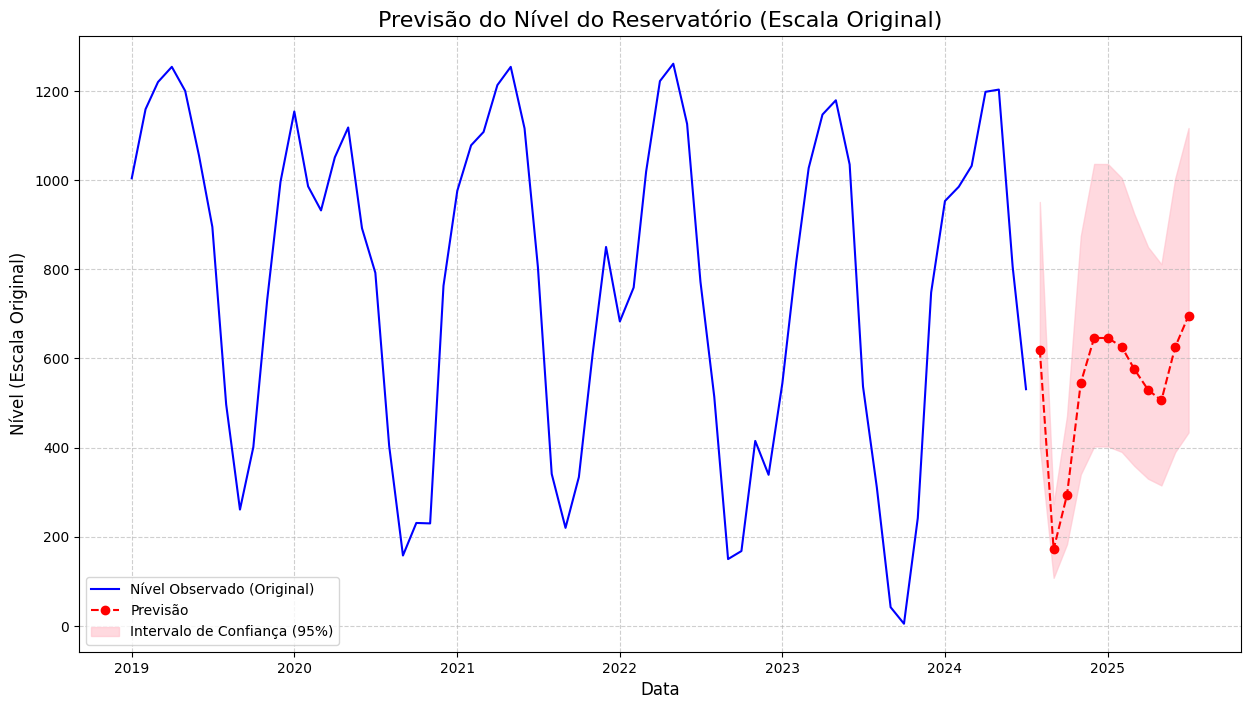

In [28]:
# --- PASSO 1: Preparar os dados para previsão ---

# Assumindo que 'results_campeao' é o resultado do seu último ajuste de modelo
# e 'exog' é o DataFrame com as variáveis exógenas originais.
# 'endog_log' é a sua série em log.

# Definir quantos meses à frente queremos prever
n_steps = 12

# --- PASSO 2: Criar o DataFrame com as variáveis exógenas para o período futuro ---

# Criar o índice de datas futuras
future_dates = pd.date_range(start=endog_log.index[-1] + pd.DateOffset(months=1), periods=n_steps, freq='MS')

# Criar o DataFrame exog_futuro
exog_futuro = pd.DataFrame(index=future_dates)

# PREMISSA: Estimar a vazão futura como a média do último ano.
# Esta é uma suposição que você pode ajustar se tiver outras informações!
vazao_estimada_futuro = exog['vazao'][-12:].mean()
exog_futuro['vazao'] = vazao_estimada_futuro

# Adicionar as colunas de dummies com valor 0 (não esperamos outliers no futuro)
for col in results_campeao.model.exog_names:
    if col not in exog_futuro.columns:
        exog_futuro[col] = 0

# Garantir que a ordem das colunas seja a mesma do modelo
exog_futuro = exog_futuro[results_campeao.model.exog_names]


# --- PASSO 3: Gerar a previsão (ainda em escala de log) ---
forecast_log = results_campeao.get_forecast(steps=n_steps, exog=exog_futuro)


# --- PASSO 4: Converter a previsão e o intervalo de confiança para a ESCALA ORIGINAL ---
previsao_original = np.exp(forecast_log.predicted_mean)
ci_original = np.exp(forecast_log.conf_int())


# --- PASSO 5: Imprimir os valores previstos ---
print("--- Previsão do Nível para os Próximos {} Meses (Escala Original) ---".format(n_steps))
tabela_previsao = pd.DataFrame({
    'Previsão': previsao_original,
    'IC Inferior (95%)': ci_original.iloc[:, 0],
    'IC Superior (95%)': ci_original.iloc[:, 1]
})
print(tabela_previsao)


# --- PASSO 6: Plotar o resultado na ESCALA ORIGINAL ---

# Converter os dados históricos de volta para a escala original para o plot
dados_originais = np.exp(endog_log)

plt.figure(figsize=(15, 8))

# Plotar os dados históricos (vamos plotar apenas os últimos 5 anos para melhor visualização)
plt.plot(dados_originais['2019':], label='Nível Observado (Original)', color='blue')

# Plotar a previsão
plt.plot(previsao_original, label='Previsão', color='red', marker='o', linestyle='--')

# Plotar o intervalo de confiança
plt.fill_between(ci_original.index,
                 ci_original.iloc[:, 0],
                 ci_original.iloc[:, 1], color='pink', alpha=0.6, label='Intervalo de Confiança (95%)')

plt.title('Previsão do Nível do Reservatório (Escala Original)', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Nível (Escala Original)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



# novo modelo

In [30]:
# Seus dados endog e exog já estão definidos
endog = dados_final['nivel']
endog_log = np.log(endog)
exog = dados_final[['vazao']]

In [33]:
# --- PASSO 0: Preparar os dados exógenos (mesmo código) ---
exog_final = exog.copy()
exog_final['outlier_2013-09-01'] = 0
exog_final.loc['2013-09-01', 'outlier_2013-09-01'] = 1

# --- PASSO 1: Definir o Grid de Hiperparâmetros ---
p = range(0, 3)
q = range(0, 3)
P = range(0, 3)
Q = range(0, 3)

pdq = list(itertools.product(p, [0], q))       # (p, d=0, q)
seasonal_pdq = [(P_, 1, Q_, 12) 
                for (P_, _, Q_) in itertools.product(P, [1], Q)]

param_grid = list(itertools.product(pdq, seasonal_pdq))
print(f"Total de combinações de parâmetros a serem testadas: {len(param_grid)}")

# --- PASSO 2: Fatiar os dados por data em TREINO e TESTE ---
train_end_date = '2023-11-01'
# os 4 meses de teste: 2023-12-01 a 2024-03-01
test_start_date = '2023-12-01'
test_end_date   = '2024-03-01'

# supondo que dados_final é um DataFrame com índice DatetimeIndex
train_data = dados_final.loc['1995-01-01':train_end_date]
test_data  = dados_final.loc[test_start_date:test_end_date]

print(f"Tamanho do Treino: {len(train_data)} observações")
print(f"Tamanho do Teste:  {len(test_data)} observações")
print("-" * 40)

# endógena e exógena de treino
endog_train = train_data['nivel']
exog_train  = train_data[['vazao', 'outlier_2013-09-01']]

# endógena e exógena de teste
endog_test = test_data['nivel']
exog_test  = test_data[['vazao', 'outlier_2013-09-01']]

# --- PASSO 3 & 4: Grid Search + Walk‐Forward no conjunto de teste ---
best_rmse = float('inf')
best_params = None

for order, seasonal_order in param_grid:
    history_endog = list(endog_train)
    history_exog  = exog_train.copy()
    predictions   = []
    
    try:
        for t in range(len(endog_test)):
            # Ajusta SARIMAX com o histórico atual
            model = sm.tsa.SARIMAX(
                endog=history_endog,
                exog=history_exog,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=True,
                enforce_invertibility=True
            )
            fit = model.fit(disp=False)
            
            # Previsão de 1 passo à frente
            future_exog = exog_test.iloc[t:t+1]
            yhat = fit.forecast(steps=1, exog=future_exog)
            predictions.append(yhat.iloc[0])
            
            # Atualiza histórico com a observação real
            history_endog.append(endog_test.iloc[t])
            history_exog = pd.concat([history_exog, future_exog])
        
        # Calcula RMSE no conjunto de teste
        rmse = np.sqrt(mean_squared_error(endog_test, predictions))
        print(f"Params SARIMAX{order}{seasonal_order} -> RMSE: {rmse:.4f}")
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (order, seasonal_order)
    
    except Exception as e:
        print(f"Params SARIMAX{order}{seasonal_order} -> FALHOU ({e})")
        continue

# --- PASSO 5: Exibir melhor configuração ---
print("\n--- Melhor modelo no Teste ---")
print(f"SARIMAX{best_params[0]}{best_params[1]} com RMSE = {best_rmse:.4f}")

Total de combinações de parâmetros a serem testadas: 81
Tamanho do Treino: 347 observações
Tamanho do Teste:  4 observações
----------------------------------------
Params SARIMAX(0, 0, 0)(0, 1, 0, 12) -> RMSE: 9.4907
Params SARIMAX(0, 0, 0)(0, 1, 1, 12) -> RMSE: 6.2148
Params SARIMAX(0, 0, 0)(0, 1, 2, 12) -> RMSE: 6.7536
Params SARIMAX(0, 0, 0)(1, 1, 0, 12) -> RMSE: 7.4328
Params SARIMAX(0, 0, 0)(1, 1, 1, 12) -> RMSE: 6.6585
Params SARIMAX(0, 0, 0)(1, 1, 2, 12) -> RMSE: 7.7765
Params SARIMAX(0, 0, 0)(2, 1, 0, 12) -> RMSE: 7.0365
Params SARIMAX(0, 0, 0)(2, 1, 1, 12) -> RMSE: 6.9690
Params SARIMAX(0, 0, 0)(2, 1, 2, 12) -> RMSE: 7.6246
Params SARIMAX(0, 0, 1)(0, 1, 0, 12) -> RMSE: 12.2830
Params SARIMAX(0, 0, 1)(0, 1, 1, 12) -> RMSE: 7.7092
Params SARIMAX(0, 0, 1)(0, 1, 2, 12) -> RMSE: 7.6409
Params SARIMAX(0, 0, 1)(1, 1, 0, 12) -> RMSE: 10.3742
Params SARIMAX(0, 0, 1)(1, 1, 1, 12) -> RMSE: 7.7052
Params SARIMAX(0, 0, 1)(1, 1, 2, 12) -> RMSE: 7.8107
Params SARIMAX(0, 0, 1)(2, 1, 0, 12) -

In [31]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import itertools
import warnings
warnings.filterwarnings("ignore") # Ignorar avisos de convergência durante o grid search

# --- PASSO 0: Preparar os dados (mesmo código que você forneceu) ---
# Assumindo que 'endog_log' e 'exog' já existem e estão prontos.
exog_final = exog.copy()
exog_final['outlier_2013-09-01'] = 0
exog_final.loc['2013-09-01', 'outlier_2013-09-01'] = 1
# exog_final['outlier_2023-10-01'] = 0
# exog_final.loc['2023-10-01', 'outlier_2023-10-01'] = 1
# datas_outliers_1995_final = ['1995-01-01', '1995-02-01']
# for data in datas_outliers_1995_final:
#     exog_final[f'outlier_{data}'] = 0
#     exog_final.loc[data, f'outlier_{data}'] = 1

# --- PASSO 1: Definir o Grid de Hiperparâmetros ---
# Definimos os valores a serem testados para p, q, P, Q.
# d=0 e D=1 são fixos com base na sua análise anterior.
p = range(0, 3) # Testa p=0, 1, 2
q = range(0, 3) # Testa q=0, 1, 2
d = range(0, 3) # Testa d=0, 1, 2
P = range(0, 3) # Testa P=0, 1, 2
D = range(0, 3) # Testa D=0, 1, 2
Q = range(0, 3) # Testa Q=0, 1, 2

# Gera todas as combinações possíveis de (p,q,P,Q)
pdq = list(itertools.product(p, [0], q)) # Ordem não sazonal (d=0 fixo)
seasonal_pdq = [(x[0], 1, x[2], 12) for x in list(itertools.product(P, [1], Q))] # Ordem sazonal (D=1, m=12 fixos)
# pdq = list(itertools.product(p, d, q)) # Ordem não sazonal (d=0 fixo)
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))] # Ordem sazonal (D=1, m=12 fixos)

param_grid = list(itertools.product(pdq, seasonal_pdq))
print(f"Total de combinações de parâmetros a serem testadas: {len(param_grid)}")

# --- PASSO 2: Dividir os dados em Treino e Validação ---
validation_size = int(len(endog_log) * 0.10) # Usaremos 20% para validação
train_endog = endog_log[:-validation_size]
train_exog = exog_final[:-validation_size]
validation_endog = endog_log[-validation_size:]
validation_exog = exog_final[-validation_size:]

print(f"Tamanho do treino: {len(train_endog)}")
print(f"Tamanho da validação: {len(validation_endog)}")

# --- PASSO 3 & 4: Loop de Grid Search e Walk-Forward Validation ---
best_rmse = float('inf')
best_params = None

for params in param_grid:
    order = params[0]
    seasonal_order = params[1]
    
    # Histórico para o walk-forward
    history_endog = [x for x in train_endog]
    history_exog = train_exog.copy()
    predictions = []

    try:
        # Loop interno: Walk-Forward
        for t in range(len(validation_endog)):
            # Ajusta o modelo com o histórico atual
            model = sm.tsa.SARIMAX(
                endog=history_endog,
                exog=history_exog,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            model_fit = model.fit(disp=False)
            
            # Previsão de 1 passo à frente
            # Precisamos fornecer o 'exog' para o ponto que queremos prever
            future_exog = validation_exog.iloc[t:t+1]
            yhat = model_fit.forecast(steps=1, exog=future_exog)
            predictions.append(yhat.iloc[0])
            
            # Atualiza o histórico com o dado real da validação
            history_endog.append(validation_endog.iloc[t])
            history_exog = pd.concat([history_exog, future_exog])

        # --- PASSO 5: Calcular o erro para esta combinação de parâmetros ---
        rmse = np.sqrt(mean_squared_error(validation_endog, predictions))
        
        print(f'Parâmetros: {order}{seasonal_order} -> RMSE: {rmse:.4f}')

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params

    except Exception as e:
        # Algumas combinações de parâmetros podem falhar, continuamos para a próxima
        print(f'Parâmetros: {order}{seasonal_order} -> FALHOU. Erro: {e}')
        continue

# --- PASSO 6: Apresentar o melhor modelo ---
print("\n--- Resultados da Validação Cruzada ---")
print(f"Melhor combinação de parâmetros: SARIMAX{best_params[0]}{best_params[1]}")
print(f"Melhor RMSE na validação: {best_rmse:.4f}")




Total de combinações de parâmetros a serem testadas: 81
Tamanho do treino: 316
Tamanho da validação: 35
Parâmetros: (0, 0, 0)(0, 1, 0, 12) -> RMSE: 0.6147
Parâmetros: (0, 0, 0)(0, 1, 1, 12) -> RMSE: 0.6654


KeyboardInterrupt: 

In [15]:
# --- PASSO 7: Treinar o Modelo Final com os Melhores Parâmetros ---
print("\n--- Ajustando o modelo final com os melhores parâmetros em TODOS os dados ---")

final_model = sm.tsa.SARIMAX(
    endog_log,
    exog=exog_final,
    order=best_params[0],
    seasonal_order=best_params[1],
    enforce_stationarity=False,
    enforce_invertibility=False
)

final_results = final_model.fit(disp=False)
print(final_results.summary())

# Agora 'final_results' é o seu modelo otimizado e treinado, pronto para fazer previsões futuras.



--- Ajustando o modelo final com os melhores parâmetros em TODOS os dados ---
                                        SARIMAX Results                                        
Dep. Variable:                                   nivel   No. Observations:                  355
Model:             SARIMAX(2, 0, 1)x(0, 2, [1, 2], 12)   Log Likelihood                -288.717
Date:                                 Thu, 24 Jul 2025   AIC                            599.435
Time:                                         18:50:28   BIC                            640.358
Sample:                                     01-01-1995   HQIC                           615.803
                                          - 07-01-2024                                         
Covariance Type:                                   opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------